## DRAFT 

<h1>Table of Contents<span class="tocSkip"></span></h1>

[FIX] with newest at the end

[Introduction and Business Case](#SI)

[1. Imports and Preliminary Exploration](#S1)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[1.1 Memory Optimization](#S1.1)

[2. EDA & Data Preprocessing](#S2)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.1 Univariate Analyses](#S2.1)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.2 Multivariate Analyses](#S2.2)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.3 Outliers](#S2.3)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.4 Final Data Preprocessing](#S2.4)

[3. Models](#S3)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.1 Useful functions](#S3.1)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.2 From Scratch](#S3.2)

[4. Clusters Interpretation](#S4)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[4.1 Conclusion](#S4.1)

[5. Limitations](#S5)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[4.1 Biases](#S5.1)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[4.1 Final Remarks](#S5.2)

[6. References](#S6)

<h1>I. Introduction <span class="tocSkip"></span></h1>


The purpose of this notebook is *the prediction of prospect customer (client who booked) 1) churn/revenues, 2) cluster they will belong to* to identify the best market segments for a hospitality business. 
This has been an opportunity to showcase my abilities in Data Science techniques and my reasoning on first principles, which will be properly introduced before their application. They are:
- multi-class classification (XGBoost, ..
- regression (RF, AdaBoost, GradientBoosting, XGBoost, ensemble of the best)


3) The third notebook has the purpose of forecasting revenues and satisfaction ratings and subsequent cluster, by using Random forest, Xgboost, adaboost, and XGBoost multiclassification for recommending systems.



<h2>I.III Business Case: Forecasting Revenues and the Market Segment of Prospect Guests<span class="tocSkip"></span></h2>

Question(s) to answer:

1. improve planning and budgeting short term
2. forecast market segment/profile of the incoming client. Can improve marketing for tailoring messages and get the most

Solution: 

1. binary classification churn or not
2. regression for ADR
3. regression for Additional revenue
4. regression for Customer Satisfaction Rating
5. multiclass classification for cluster (other simpler ? alternatives, but i want to tackle the multiclas classification model)


Useful in planning, budgeting short term. And long term.

With deeper and higher quality of data, can be adapted to recommending algorithm, on-line or at check-in (both in-app and at the reception, similarly to MARRIOTT HOTELS).

In fact, I then build a model to forecast in which cluster the prospect client is going to be. Hence, it allows marketing departments to customize messages to the incoming clients.

> For forecasting cancelled status https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwj26JPukqzsAhXPCuwKHY_FBQIQFjAAegQIARAC&url=https%3A%2F%2Fdialnet.unirioja.es%2Fdescarga%2Farticulo%2F5921001.pdf&usg=AOvVaw1EmdDaUArMjpYEHr_tdDQZ

## Overview 
**I think i should also compare results of normal dataset vs extended dataset**

**FOR REVENUE - RATINGS**
1. EDA
    - Missing Values
    - Target Variable (Distribution)
    - Independent Variables (Distribution, Correlation)
    

2. Data Preprocessing:
    - ((Feature selection (explanatory power, lasso regression) - perhaps not in this section (TBD)
    - Encoding
        - labels
        - one-hot encoding (ColumnTransformer for production or get_dummies for easy practice) [not for linear regression StatQuest??]
    - TRAIN-VAL-TEST Split (stratified) [VAL only for classifier problems]
    - Data Scaling (**only after splitting!**)
    


3. Models Creation:
    - 3 Models to be used from the list below:
        - Linear regression
        - (4) xgboost [..
        - LGBMRegressor [..
        - (1) Randomforest
        - (3) gradient boosting?
        - catboost [..
        - (2) Adaboost
        - Last ensemble model: sklearn.ensemble.VotingRegressor for regression, VotingClassifier for clusters
            - chosen from top 25% - 33%: XXXX
    - Accuracy metric for regression: MSE, RMSE, MedianAE (more robust to outlier), Poisson if Poisson distribution/regression
    - For each model:
        - ((Train on TRAIN + VAL dataset and evaluate on TEST dataset
        - Hyperparameter tuning: GridSearch for finding best combinations of parameters;
    - Best Model Selection:
        - **Nested Cross validation**: Nested cross-validation (CV) is often used to train a model in which hyperparameters also need to be optimized. (https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html)
        - Select the best model based on VAL accuracy;


3. **Best Appraoch**
    - experimenting with some hyperparameters, no nested-crossvalidation
        - MAYBE my function?
    - center the hyperparameters, provide a list of three for each
    - run the following, with NUM_TRIALS = 3-5, param_grid, kfold=3-10 depending on the dataset
    - [to test] pipeline with multiple estimators, same proceeding
    - the mean result, is used to compare the different estimators


4. Final Model:
    - Whole dataset on best model



Since the dataset is not that large, I will perform k-fold cross-validation (GridSearchCV).



Dataset is limited. Wish to have variables:

- Seasons: cannot now, only 4 months. by observing first total REVENUE of all customers by day
- Marketing data
- more detailed bookings data
- XXXX

<a id='S1'></a>
# Imports

In [1]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
from datetime import datetime
import pycountry
import re
from tqdm.notebook import tqdm

from functions import ModelsParameters
from functions import ModelsParameters as mp  # FIX

import matplotlib.pyplot as plt
import plotly.graph_objs as go
import seaborn as sns
from scipy.stats import gaussian_kde

from sklearn.metrics import pairwise_distances  # For spectral clustering from scratch
from sklearn.feature_extraction import text # how to use it?
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.preprocessing import normalize, MinMaxScaler, scale, minmax_scale, StandardScaler, RobustScaler
from sklearn import preprocessing
from sklearn.cluster import DBSCAN
import random
import sklearn.metrics
from sklearn.pipeline import Pipeline

from scipy.stats.mstats import winsorize

from sklearn.svm import SVC

# For XGBoost Regression and Classification
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, f1_score, r2_score, mean_absolute_error

import catboost 

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

import lightgbm

from sklearn.linear_model import LinearRegression

from sklearn.ensemble import VotingRegressor
# autoreload changes in custom modules
%load_ext autoreload
%autoreload 2

from IPython.display import Markdown as md
pd.options.display.max_columns = 50
%matplotlib inline
sns.set_style('darkgrid', {'axes.facecolor': '.9'})

In [38]:
for i in tqdm(range(1, 10000)):
    i += i
    

In [2]:
""" Parameters Settings """
NUM_SAMPLE_1 = 59000  # Max is 59607. Smaller size helps during development
NUM_SAMPLE_2 = 5050  # Max is 33750.

In [3]:
hotel_sc = pd.read_csv("hotel_sc.csv")
hotel_canceled = pd.read_csv("hotel_canceled.csv")

hotel_sc = hotel_sc.sample(n=NUM_SAMPLE_2, random_state=42)
hotel_canceled = hotel_canceled.sample(n=int(len(hotel_canceled)*(NUM_SAMPLE_2/59607)), random_state=42)
hotel_sc.drop(columns=['Unnamed: 0'], inplace=True)
hotel_canceled.drop(columns=['Unnamed: 0'], inplace=True)

In [4]:
hotel_sc.shape

(5050, 37)

In [5]:
hotel_canceled.head()

,Is Cancelled,Lead Time,Weekend Nights,Week Nights,Adults,Children,Babies,Meal,Country,Travelling Group,Distribution Channel,Is Repeated Guest,Previous Cancellation,Previous Bookings Not Cancelled,Reserved Room Type,Assigned Room Type,Booking Changes,Customer Type,# Special Requests,Age,Nights,ADR,Bar,Restaurant,Breakfast,Other,Additional Expenditures,Arrival Date,Customer Satisfaction Rating,Cluster
22816,1,4,0,1,1,0.0,0,BB,Denmark,Couples,Direct,1,2,10,D,A,1,Transient,2,33,1,0.0,124,302.0,49.0,27.0,502.0,2016-12-09,NaN,-1
23080,1,309,0,2,2,0.0,0,BB,Denmark,Groups,TA/TO,0,0,0,A,A,0,Transient,0,30,2,2852.0,461,1234.0,332.0,31.0,2058.0,2016-12-12,NaN,-1
10819,1,32,1,1,1,0.0,0,BB,Denmark,Groups,TA/TO,0,0,0,A,A,0,Transient,0,34,2,3450.0,293,592.0,58.0,11.0,954.0,2016-09-20,NaN,-1
11326,1,149,2,2,2,0.0,0,SC,Brazil,Couples,TA/TO,0,0,0,A,A,1,Transient,1,59,4,3440.8,834,2536.0,290.0,42.0,3702.0,2016-09-24,NaN,-1
3931,1,157,0,4,2,0.0,0,SC,Spain,Couples,TA/TO,0,0,0,A,A,0,Transient,0,32,4,5750.0,816,2441.0,319.0,49.0,3625.0,2016-08-02,NaN,-1


In [6]:
hotel_sc.head()

,index,Is Cancelled,Lead Time,Weekend Nights,Week Nights,Adults,Children,Babies,Meal,Country,Travelling Group,Distribution Channel,Is Repeated Guest,Previous Cancellation,Previous Bookings Not Cancelled,Reserved Room Type,Assigned Room Type,Booking Changes,Customer Type,# Special Requests,Age,Nights,ADR,Bar,Restaurant,Breakfast,Other,Additional Expenditures,Arrival Date,Customer Satisfaction Rating,Additional Expenditures by day,ADR Adjusted,anomaly,ADR Adjusted - Scaled,Customer Satisfaction Rating - Scaled,Cluster,Cluster Profile
13217,22468,0,12,1,3,2,1,0,SC,France,Family,TA/TO,0,0,0,A,A,0,Transient,1,37,4,2649.6,778,3108,219,72,4177,2016-09-09,6.594,1044.2500,3693.850,1,0.23970,0.6587,4,Low Revenue - Medium Satisfaction
31960,56488,0,60,1,1,2,1,0,BB,France,Family,TA/TO,0,0,0,A,A,0,Transient,1,40,2,5837.4,362,1791,181,79,2413,2016-12-21,4.965,1206.5000,7043.900,1,0.48780,0.4960,5,Medium Revenue - Low Satisfaction
24805,43455,0,15,1,2,2,0,0,BB,Slovenia,Couples,TA/TO,0,0,0,A,A,0,Transient,2,26,3,9200.0,705,2052,302,56,3115,2016-11-07,8.660,1038.3334,10238.333,1,0.72460,0.8647,0,High Revenue - High Satisfaction
13150,22361,0,10,1,1,2,0,0,BB,Denmark,Couples,Direct,0,0,0,A,A,0,Transient,1,24,2,92.0,452,1267,175,52,1946,2016-09-08,7.980,973.0000,1065.000,1,0.04507,0.7974,4,Low Revenue - Medium Satisfaction
16084,27420,0,2,0,2,2,0,0,BB,Belgium,Couples,Direct,0,0,0,A,A,0,Transient,0,32,2,3850.2,519,1374,197,42,2132,2016-09-23,6.047,1066.0000,4916.200,1,0.33030,0.6040,5,Medium Revenue - Low Satisfaction


In [7]:
## Drop Columns not needed, because I am going to concatenate the two datasets (considering all data)
hotel_sc.drop(columns=['anomaly', 'ADR Adjusted - Scaled', 'Customer Satisfaction Rating - Scaled',
                       'index'], inplace=True)

## Create Cluster columns
hotel_canceled['Cluster'] = 8
hotel_canceled['Cluster Profile'] = 'Canceled'

## Concatenate
hotel = pd.concat([hotel_sc, hotel_canceled])
hotel.sort_values('Arrival Date', inplace=True)
hotel = hotel.reset_index(drop=True)
hotel.head()

,Is Cancelled,Lead Time,Weekend Nights,Week Nights,Adults,Children,Babies,Meal,Country,Travelling Group,Distribution Channel,Is Repeated Guest,Previous Cancellation,Previous Bookings Not Cancelled,Reserved Room Type,Assigned Room Type,Booking Changes,Customer Type,# Special Requests,Age,Nights,ADR,Bar,Restaurant,Breakfast,Other,Additional Expenditures,Arrival Date,Customer Satisfaction Rating,Additional Expenditures by day,ADR Adjusted,Cluster,Cluster Profile
0,0,257,0,2,2,0.0,0,HB,Denmark,Couples,TA/TO,0,0,0,A,A,0,Transient,0,32,2,4669.0,354,1176.0,205.0,21.0,1756.0,2016-07-01,5.010,878.0,5547.0,5,Medium Revenue - Low Satisfaction
1,0,257,0,2,2,0.0,0,HB,Denmark,Couples,TA/TO,0,0,0,A,A,0,Transient,0,28,2,4669.0,553,1262.0,241.0,41.0,2097.0,2016-07-01,4.480,1048.5,5717.5,1,High Revenue - Low Satisfaction
2,0,257,0,2,2,0.0,0,HB,Denmark,Couples,TA/TO,0,0,0,A,A,0,Transient,0,27,2,4669.0,459,1308.0,28.0,39.0,1834.0,2016-07-01,8.700,917.0,5586.0,2,Low Revenue - High Satisfaction
3,0,3,0,1,2,0.0,0,BB,Ireland,Family,TA/TO,0,0,0,A,A,2,Transient,1,52,1,8280.0,199,709.0,107.0,34.0,1049.0,2016-07-01,9.555,1049.0,9329.0,0,High Revenue - High Satisfaction
4,0,257,0,2,2,0.0,0,HB,Denmark,Couples,TA/TO,0,0,0,A,A,0,Transient,0,26,2,4669.0,306,1189.0,139.0,38.0,1672.0,2016-07-01,5.516,836.0,5505.0,5,Medium Revenue - Low Satisfaction


In [8]:
hotel.shape

(7223, 33)

In [9]:
hotel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7223 entries, 0 to 7222
Data columns (total 33 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Is Cancelled                     7223 non-null   int64  
 1   Lead Time                        7223 non-null   int64  
 2   Weekend Nights                   7223 non-null   int64  
 3   Week Nights                      7223 non-null   int64  
 4   Adults                           7223 non-null   int64  
 5   Children                         7223 non-null   float64
 6   Babies                           7223 non-null   int64  
 7   Meal                             7223 non-null   object 
 8   Country                          7223 non-null   object 
 9   Travelling Group                 7223 non-null   object 
 10  Distribution Channel             7223 non-null   object 
 11  Is Repeated Guest                7223 non-null   int64  
 12  Previous Cancellatio

## Memory Optimization

For reducing time and memory required by the models, I have previously built a function that optimizes the data format according to variables characteristics. In this case, being only 32 features and 59607 entries, it is not strictly necessary to proceed. Yet, it is a good practice that I stick to. Furthermore, as a side product, it also pre-checks whether all the values in each columns are either all integer/float/strings. If that is not the case, it raises a warning and I can investigate the issue.

*Caveat*: in the coming model I deem not to need a high level of precision of the current `float64` variables. If that were the case, I would proceed differently.


Furthermore, I do 'category', but it has to be handled with attention if XXXX 
> https://pbpython.com/pandas_dtypes_cat.html

https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html

Reminder for data types
> https://jakevdp.github.io/PythonDataScienceHandbook/02.01-understanding-data-types.html

In [ ]:
# FIX could be used to simplify the optimize function
len(hotel.loc[~hotel['Assigned Room Type'].str.isdigit(), 'Assigned Room Type'])

In [10]:
## Function to optimize the format of the features
def optimize_memory(df, categorical='no'):
    for col in tqdm(df.columns):
        number = 0
        strings = 0
        for i in df[col]: 
            if (type(i) == int) | (type(i) == float): number += 1
            elif (type(i) == str): strings += 1
            else: pass
            
        if number == len(df[col]):
            integer = 0
            for i in df[col]: 
                if i % 1 == 0: integer += 1
                else: pass
            if (df[col].max()<128) & (df[col].min()>=-128) & (integer==len(df[col])): 
                df[col] = df[col].astype('int8')
            elif (df[col].max()<128) & (df[col].min()>=-128) & (integer!=len(df[col])): 
                df[col] = df[col].astype('float16')
            elif (df[col].max()<32768) & (df[col].min()>=-32768) & (integer==len(df[col])): 
                df[col] = df[col].astype('int32')
            elif (df[col].max()<32768) & (df[col].min()>=-32768) & (integer!=len(df[col])): 
                df[col] = df[col].astype('float32')
            elif (df[col].max()>=32768) & (df[col].min()<-32768) & (integer==len(df[col])): 
                df[col] = df[col].astype('int64')
            elif (df[col].max()>=32768) & (df[col].min()<-32768) & (integer!=len(df[col])): 
                df[col] = df[col].astype('float64')
        
        elif (strings == len(df[col])) & (categorical == 'yes'): 
            # TO BE improved
            #df = pd.DataFrame({"A": list("abca"), "B": list("bccd")})
            #cat_type = CategoricalDtype(categories=list("abcd"), ordered=True)
            df[col] = df[col].astype("category")
        
        elif (strings == len(df[col])) & (categorical == 'no'): 
            pass
        
        else: print('Explore the dataset, there are cases not contemplated and/or irregularities')
            
    return df

hotel = optimize_memory(hotel)

In [11]:
hotel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7223 entries, 0 to 7222
Data columns (total 33 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Is Cancelled                     7223 non-null   int8   
 1   Lead Time                        7223 non-null   int32  
 2   Weekend Nights                   7223 non-null   int8   
 3   Week Nights                      7223 non-null   int8   
 4   Adults                           7223 non-null   int8   
 5   Children                         7223 non-null   int8   
 6   Babies                           7223 non-null   int8   
 7   Meal                             7223 non-null   object 
 8   Country                          7223 non-null   object 
 9   Travelling Group                 7223 non-null   object 
 10  Distribution Channel             7223 non-null   object 
 11  Is Repeated Guest                7223 non-null   int8   
 12  Previous Cancellatio

# EDA & Data Preprocessing

The next step is to check and validate the data for anomalies, outliers, missing values.

**OBS**

**[if i can manage to do multivairate outliers keep this structure. Else, I put the outlier analysis in the univariate analysis at the top]**

**[Encoding - where it applies - could also be done as part of the univariate analysis]**

**[how to decide if a var is relevant?]**


----

The structure of this Section is as follows:

- Univariate Analysis for all variables:
    - missing values
    - 0 and infinite values
    - distribution
- Encoding
    - label
    - one-hot encoding
    - ..
- Multivariate Analyses:
    - correlation
    - scatterplots and KDE
- Outliers:
    - univariate outliers
    - multivariate: Isolation Forest [not good with high dimensionality?]
- final memory optimization
    
    
-----

## Univariate Analysis

PP: Then create dataset for all ages, each row the same for each of those column

**Shall I do ADR adjusted by the number in the room/max available? 1 for adults, 0.7 for children. Do EDA for finding it out by TYPE and NUMBER OF PEOPLE INSIDE**

Children 0.7 of Adults (only on room)

I will analyse the targets and important features later, in the appropriate sections. Here, I focus on common important features, ADR adjusted by the persons.



Upselling value is total over the period considered.


In [12]:
""" OLD CODE CAN BE USEFUL FOR THE STRUCTURE """

"""def extend_adults(df):
    s = pd.DataFrame()
    for i in df.index:
        s = s.append([pd.DataFrame(data=[list(df.values[i])]*int(df['Adults'][i]))], ignore_index=True)
    s.columns = df.columns
    return s"""

# hotel['TimeArrival'] = hotel['TimeArrival'].apply(lambda x: x.strftime('%Y-%m-%d'))

"def extend_adults(df):\n    s = pd.DataFrame()\n    for i in df.index:\n        s = s.append([pd.DataFrame(data=[list(df.values[i])]*int(df['Adults'][i]))], ignore_index=True)\n    s.columns = df.columns\n    return s"

### Weighted ADR [?

Adjusted to Room capacity

'Weight per Person' will be used to calculate the new 


Information given earlier to: Additional Expenditures value is total over the period considered.


Per day revenues

Total ADR: ADR + Additional Expenditures/Nights

Total Revenues: ADR * nights + Additional Expenditures


In [9]:
hotel['Total ADR'] = hotel['ADR'] + hotel['Additional Expenditures'] / hotel['Nights']
hotel['Total Revenues'] = hotel['ADR'] * hotel['Nights'] + hotel['Additional Expenditures']  # Not very necessary
hotel['Total ADR'] = np.where(hotel['Total ADR'] == np.inf, 0, hotel['Total ADR'])

In [10]:
hotel['Reserved Room Type'].value_counts()

A                   46313
D                    8780
F                    1353
E                    1123
B                    1052
G                     363
P                       8
C                       8
Name: Reserved Room Type, dtype: int64

In [11]:
hotel['Assigned Room Type'].value_counts()

A                   42190
D                   11129
B                    1696
E                    1593
F                    1529
G                     519
K                     215
C                     121
P                       8
Name: Assigned Room Type, dtype: int64

In [12]:
hotel['Children Adj'] = hotel['Children'] * 0.7
hotel['Persons'] = hotel['Adults'] + hotel['Children'] 
hotel['Persons Adj'] = hotel['Adults'] + hotel['Children Adj'] 
hotel[['Adults', 'Children Adj', 'Persons Adj']].groupby(hotel['Assigned Room Type']).max()

,Adults,Children Adj,Persons Adj
Assigned Room Type,,,
A,3,2.101562,3.699219
B,3,2.101562,4.398438
C,3,1.400391,3.400391
D,4,2.101562,4.000000
E,4,1.400391,4.000000
F,4,2.101562,4.101562
G,4,2.101562,4.398438
K,3,0.700195,3.699219
P,0,0.000000,0.000000


In [13]:
rooms_weights = hotel[['Adults', 'Children Adj', 'Persons Adj']].groupby(hotel['Assigned Room Type']).max()

In [14]:
""" OBS. SOMETHING SEEMS ODD. Just goes through it one more time """
rooms = list(rooms_weights.index)
weights = list(rooms_weights['Persons Adj'])
dictionary_persons = dict(zip(rooms, weights))
hotel['Weight per Person'] = hotel['Assigned Room Type']
hotel['Weight per Person'] = hotel['Weight per Person'].replace(to_replace=dictionary_persons)
hotel['Weight per Person']

0        4.101562
1        4.000000
2        3.699219
3        3.699219
4        3.699219
           ...   
58995    3.699219
58996    3.699219
58997    3.699219
58998    4.000000
58999    3.699219
Name: Weight per Person, Length: 59000, dtype: float64

In [15]:
hotel['ADR Weighted'] = round(hotel['Total ADR'] * hotel['Weight per Person'], ndigits=2)
hotel['ADR Weighted']

0        21216.56
1        20528.00
2         1975.38
3         8652.47
4         9427.46
           ...   
58995    10237.09
58996    10338.08
58997    11535.40
58998    15508.00
58999    12432.27
Name: ADR Weighted, Length: 59000, dtype: float64

In [16]:
hotel = optimize_memory(hotel)
hotel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59000 entries, 0 to 58999
Data columns (total 39 columns):
IsCanceled                         59000 non-null int8
LeadTime                           59000 non-null int32
Adults                             59000 non-null int8
Children                           58998 non-null float16
Babies                             59000 non-null int8
Meal                               59000 non-null object
Country                            59000 non-null object
Travelling Group                   59000 non-null object
Distribution Channel               59000 non-null object
Is Repeated Guest                  59000 non-null int8
Previous Cancellation              59000 non-null int8
Previous Bookings Not Cancelled    59000 non-null int8
Reserved Room Type                 59000 non-null object
Assigned Room Type                 59000 non-null object
Booking Changes                    59000 non-null int8
Deposit Type                       59000 non-null 

**ATTENTION THERE IS CUSTOMER SAT RAT NO SCALED TOO MUCH. or are just messed**

### Adults, Children, Persons [weighted?

Since children spend less, for forecasting ADR would make more sense to have weighted? FIX

In [13]:
## Quick Check of Children values
md("There are {} null values and {} inf values in the `Children` variable".
   format(hotel['Children'].isnull().sum(),
          hotel['Children'].isin([np.inf]).sum()))

There are 0 null values and 0 inf values in the `Children` variable

In [14]:
hotel = hotel.loc[~hotel['Children'].isnull()].copy()

In [15]:
## Quick Check of Children values
md("There are {} null values and {} inf values in the `Children` variable".
   format(hotel['Children'].isnull().sum(),
          hotel['Children'].isin([np.inf]).sum()))

There are 0 null values and 0 inf values in the `Children` variable

In [16]:
## Quick Check of Adults values
md("There are {} null values and {} inf values in the `Adults` variable".
   format(hotel['Adults'].isnull().sum(),
          hotel['Adults'].isin([np.inf]).sum()))

There are 0 null values and 0 inf values in the `Adults` variable

In [17]:
hotel['Persons'] = hotel['Children'] + hotel['Adults']

## Multivariate Analyses

### Correlation Matrix

Correlation for categorical values: XXXX

https://www.google.com/search?client=firefox-b-d&q=anova+vs+lda

https://yusout.com/2019/04/29/dealing-with-noisy-data-in-data-science/ for matrix on anova, chi, lda, continous categorical

"For  traditional  linear  regression models that focus on the interpretation of the impact of regressors, high correlations may lead to multicollinearity problems; however, ensemble models that Fig. 2    Correlation matrix of the variables
1 3Forecasting of Real GDP Growth Using Machine Learning Models:...focus  on  prediction,  such  as  the  gradient  boosting  and  random  forest  models,  are  designed  to  handle  multicollinearity  problems  using  decision  trees,  which,  instead  of  using  all  the  predictors,  choose  certain  regressors  to  maximize  prediction  accu-racy and are robust to multicollinearity problems (Sandri and Zuccolotto 2008)"

In [18]:
hotel.describe()

,Is Cancelled,Lead Time,Weekend Nights,Week Nights,Adults,Children,Babies,Is Repeated Guest,Previous Cancellation,Previous Bookings Not Cancelled,Booking Changes,# Special Requests,Age,Nights,ADR,Bar,Restaurant,Breakfast,Other,Additional Expenditures,Customer Satisfaction Rating,Additional Expenditures by day,ADR Adjusted,Cluster,Persons
count,7223.000000,7223.000000,7223.000000,7223.000000,7223.000000,7223.000000,7223.000000,7223.000000,7223.000000,7223.000000,7223.000000,7223.000000,7223.000000,7223.000000,7223.000000,7223.000000,7223.000000,7223.000000,7223.000000,7223.000000,5050.000000,5050.000000,5050.000000,7223.000000,7223.000000
mean,0.300845,100.308044,0.790253,2.138170,1.845770,0.286585,0.006507,0.027136,0.062163,0.159214,0.219576,0.611934,39.084729,2.928423,4869.998535,604.057040,1932.760487,312.542295,44.650838,2894.010660,6.460938,966.980408,5904.044434,4.554340,2.132355
std,0.458657,104.095709,0.868319,1.396484,0.522571,0.498512,0.083782,0.162490,0.404401,1.947273,0.676355,0.817224,13.535281,1.765151,1752.492676,419.987168,1337.203404,238.078468,16.736599,1949.922005,1.842773,296.714478,1801.507935,2.825548,0.729513
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,0.000000,0.000000,0.000000,0.000000,-8.000000,0.000000,0.000000,0.003017,167.428574,474.500000,0.000000,0.000000
25%,0.000000,19.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,29.000000,2.000000,3680.000000,293.000000,970.000000,142.000000,32.000000,1459.000000,5.187500,865.083313,4631.250000,2.000000,2.000000
50%,0.000000,67.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,36.000000,3.000000,4584.819824,517.000000,1740.000000,258.000000,45.000000,2598.000000,6.609375,999.333313,5553.344238,5.000000,2.000000
75%,1.000000,149.000000,1.000000,3.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,46.500000,4.000000,5796.000000,802.000000,2535.500000,409.000000,55.000000,3794.000000,7.816406,1125.223145,6829.035156,8.000000,3.000000
max,1.000000,629.000000,13.000000,30.000000,4.000000,3.000000,2.000000,1.000000,13.000000,71.000000,15.000000,5.000000,95.000000,43.000000,14076.000000,5335.000000,17907.000000,2511.000000,119.000000,25369.000000,10.000000,2101.750000,13959.000000,8.000000,5.000000


In [19]:
def correlation_matrix(df,
                       *cols,
                       cmap='RdBu_r',
                       center=0,
                       annot=True,
                       rotationx=45,
                       rotationy=0,
                       linewidths=.01,
                       xticklabels=1,
                       method='pearson',  # method : {'pearson', 'kendall', 'spearman'} 
                       bar_orientation="horizontal",
                      ):

    count_columns = 0
    for col in cols:
        count_columns += 1

    if (count_columns == 0) & (len(df.columns) < 20):
        plt.figure(figsize=(len(df.columns) * 1.5, len(df.columns) * 1.5))
    elif (count_columns == 0) & (len(df.columns) > 20):
        plt.figure(figsize=(30, 30))
    elif (count_columns < 20) & (count_columns != 0):
        plt.figure(figsize=(count_columns * 1.5, count_columns * 1.5))
    else:
        plt.figure(figsize=(30, 30))

    if count_columns > 0:
        ax = sns.heatmap(df[[col for col in cols]].corr(method=method),
                         cmap=cmap,
                         annot=annot,
                         center=center,
                         linewidths=linewidths,
                         xticklabels=xticklabels,
                         cbar_kws={"orientation": bar_orientation})
    else:
        ax = sns.heatmap(df.corr(method=method),
                         cmap=cmap,
                         annot=annot,
                         center=center,
                         linewidths=linewidths,
                         xticklabels=xticklabels,
                         cbar_kws={"orientation": bar_orientation})

    ax.set_xticklabels(ax.get_xticklabels(),
                       rotation=rotationx,
                       horizontalalignment='right')
    ax.set_yticklabels(ax.get_xticklabels(),
                       rotation=rotationy,
                       horizontalalignment='right')
    plt.show()

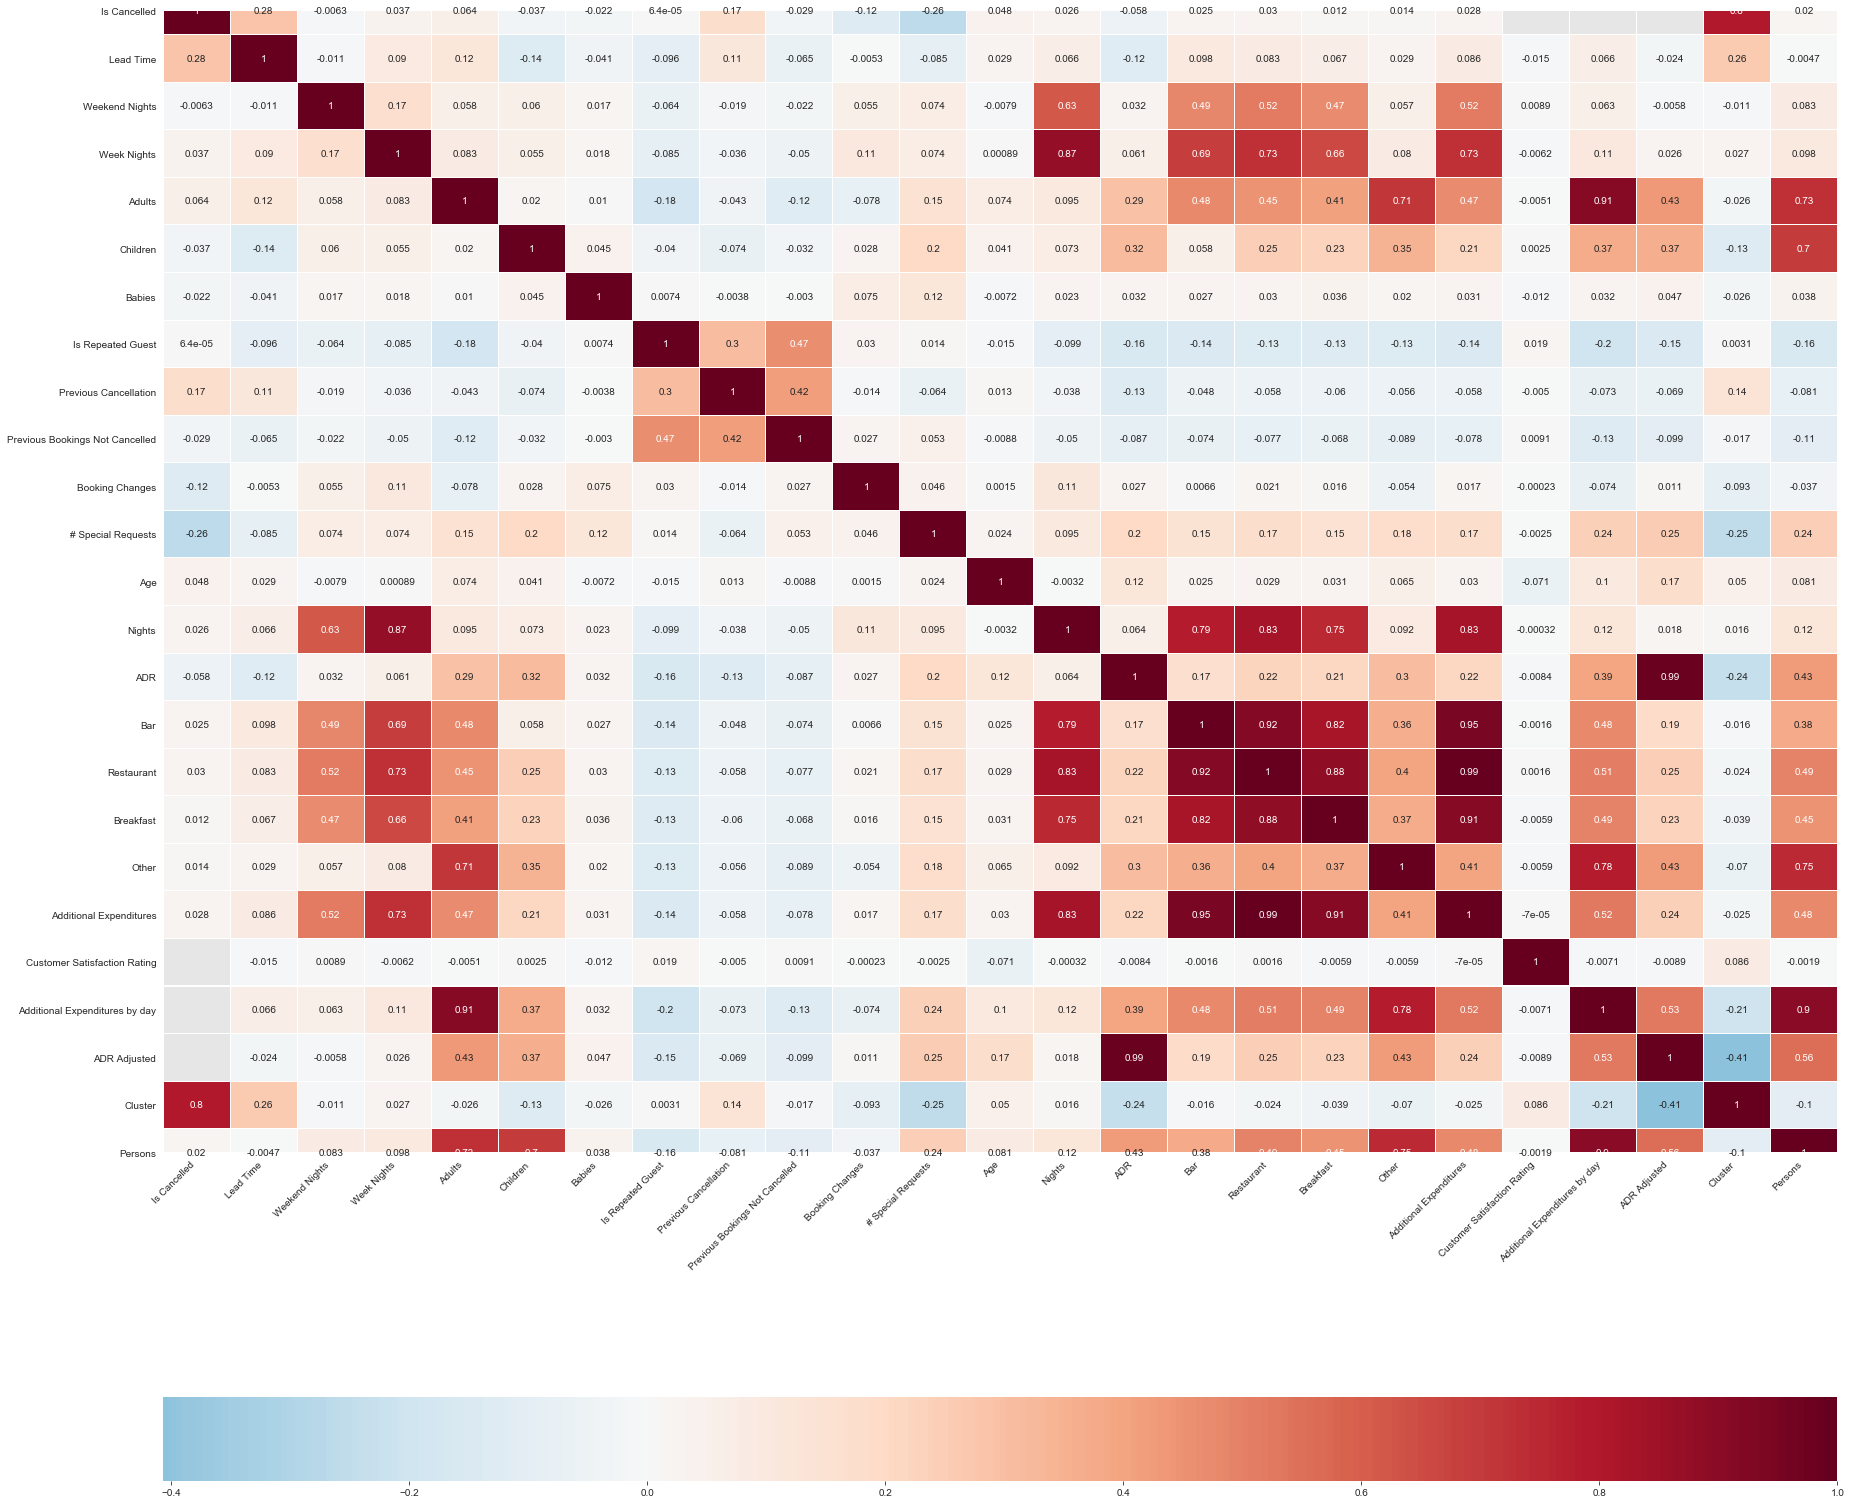

In [20]:
correlation_matrix(hotel)

### Correlation with categorical features

## Outliers Multivariate

## Encoding

In [21]:
hotel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7223 entries, 0 to 7222
Data columns (total 34 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Is Cancelled                     7223 non-null   int8   
 1   Lead Time                        7223 non-null   int32  
 2   Weekend Nights                   7223 non-null   int8   
 3   Week Nights                      7223 non-null   int8   
 4   Adults                           7223 non-null   int8   
 5   Children                         7223 non-null   int8   
 6   Babies                           7223 non-null   int8   
 7   Meal                             7223 non-null   object 
 8   Country                          7223 non-null   object 
 9   Travelling Group                 7223 non-null   object 
 10  Distribution Channel             7223 non-null   object 
 11  Is Repeated Guest                7223 non-null   int8   
 12  Previous Cancellatio

### Label encoding

1. see how many classes there are in each (if too few of many, consider put under "other")

In [22]:
hotel['Travelling Group'].value_counts()

Couples            3438
Family             1916
Groups             1088
Business            407
Solo Travellers     374
Name: Travelling Group, dtype: int64

In [23]:
## Showing how LabelEncoder() works
labels = preprocessing.LabelEncoder()
labels.fit(hotel['Travelling Group'])
list(labels.classes_)
# Inverse process using the same model
# list(labels.inverse_transform(hotel['Travelling Group']))

['Business', 'Couples', 'Family', 'Groups', 'Solo Travellers']

In [24]:
## Function to easily apply it to all relevant features
def label_encoding(df, feature):
    labels = preprocessing.LabelEncoder()
    labels.fit(df[str(feature)])
    df[str(feature)] = labels.transform(df[str(feature)])    
    return df, list(labels.inverse_transform(df[str(feature)]))

In [25]:
# Encoding all Categories
hotel_encoded, travelling_group = label_encoding(hotel, 'Travelling Group')
hotel_encoded, country = label_encoding(hotel_encoded, 'Country')
hotel_encoded, customer_type = label_encoding(hotel_encoded, 'Customer Type')
hotel_encoded, distribution_channel = label_encoding(hotel_encoded, 'Distribution Channel')
hotel_encoded, reserved_room = label_encoding(hotel_encoded, 'Reserved Room Type')

hotel_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7223 entries, 0 to 7222
Data columns (total 34 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Is Cancelled                     7223 non-null   int8   
 1   Lead Time                        7223 non-null   int32  
 2   Weekend Nights                   7223 non-null   int8   
 3   Week Nights                      7223 non-null   int8   
 4   Adults                           7223 non-null   int8   
 5   Children                         7223 non-null   int8   
 6   Babies                           7223 non-null   int8   
 7   Meal                             7223 non-null   object 
 8   Country                          7223 non-null   int32  
 9   Travelling Group                 7223 non-null   int32  
 10  Distribution Channel             7223 non-null   int32  
 11  Is Repeated Guest                7223 non-null   int8   
 12  Previous Cancellatio

### One-hot encoding

In [26]:
hotel_oh_encoded = pd.get_dummies(hotel, columns=['Country',
                               'Travelling Group',
                               'Distribution Channel',
                               'Reserved Room Type',
                               'Customer Type',
                               '# Special Requests',
                               
                              ])

In [27]:
hotel_oh_encoded['Country_1'].unique()

array([0, 1], dtype=uint8)

## Memory Optimization

In [28]:
# Taken from above
## Function to optimize the format of the features
def optimize_memory(df):
    for col in tqdm(df.columns):
        number = 0
        strings = 0
        for i in df[col]: 
            if (type(i) == int) | (type(i) == float): number += 1
            elif (type(i) == str): strings += 1
            else: pass
            
        if number == len(df[col]):
            integer = 0
            for i in df[col]: 
                if i % 1 == 0: integer += 1
                else: pass
            if (df[col].max()<128) & (df[col].min()>=-128) & (integer==len(df[col])): 
                df[col] = df[col].astype('int8')
            elif (df[col].max()<128) & (df[col].min()>=-128) & (integer!=len(df[col])): 
                df[col] = df[col].astype('float16')
            elif (df[col].max()<32768) & (df[col].min()>=-32768) & (integer==len(df[col])): 
                df[col] = df[col].astype('int32')
            elif (df[col].max()<32768) & (df[col].min()>=-32768) & (integer!=len(df[col])): 
                df[col] = df[col].astype('float32')
            elif (df[col].max()>=32768) & (df[col].min()<-32768) & (integer==len(df[col])): 
                df[col] = df[col].astype('int64')
            elif (df[col].max()>=32768) & (df[col].min()<-32768) & (integer!=len(df[col])): 
                df[col] = df[col].astype('float64')
        
        elif strings == len(df[col]): pass
        
        else: print('Explore the dataset, there are cases not contemplated and/or irregularities')
            
    return df


hotel_encoded = optimize_memory(hotel_encoded)
hotel_oh_encoded = optimize_memory(hotel_oh_encoded)

In [29]:
hotel_oh_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7223 entries, 0 to 7222
Columns: 126 entries, Is Cancelled to # Special Requests_5
dtypes: float16(1), float32(3), int32(5), int8(113), object(4)
memory usage: 1.3+ MB


In [30]:
hotel_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7223 entries, 0 to 7222
Data columns (total 34 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Is Cancelled                     7223 non-null   int8   
 1   Lead Time                        7223 non-null   int32  
 2   Weekend Nights                   7223 non-null   int8   
 3   Week Nights                      7223 non-null   int8   
 4   Adults                           7223 non-null   int8   
 5   Children                         7223 non-null   int8   
 6   Babies                           7223 non-null   int8   
 7   Meal                             7223 non-null   object 
 8   Country                          7223 non-null   int8   
 9   Travelling Group                 7223 non-null   int8   
 10  Distribution Channel             7223 non-null   int8   
 11  Is Repeated Guest                7223 non-null   int8   
 12  Previous Cancellatio

In [31]:
""" For writing functions in PyCharm FIX """

hotel_encoded.to_csv('hotel_test.csv')

# Pre-modelling functions // [FIX title]

The risk is selecting data transforms prior to selecting models might mean that you miss the data preparation sequence that gets the most out of an algorithm >https://machinelearningmastery.com/combined-algorithm-selection-and-hyperparameter-optimization/

In this Section I will proceed in the following way:

- for each estimator/model:
    - explanation/theory, possibly from scratch
- functions for resampling methods, Hyperparameters optimization, Pipeline for data transforms
- evaluation metrics

However, it is seldom known in advance which procedure will perform best or even well for any given problem. p. 350 EoSL

![title](img/overview_models.png)

In [2]:
"""  Only for developing purposes. Same as below """
hotel_encoded = pd.read_csv("hotel_test.csv")
hotel_encoded = hotel_encoded.sample(n=100, random_state=42)
hotel_encoded.drop(columns=['Unnamed: 0'], inplace=True)
## Feautures to be excluded to avoid data leakage
hotel_encoded_clients = hotel_encoded.loc[hotel_encoded['Cluster']!=8].copy()  # 8 was for canceled ones
drop_feature = [
 'Lead Time',
 'Is Cancelled',
 'Babies',
 'Meal',
 'Is Repeated Guest',
 'Previous Cancellation',
 'Previous Bookings Not Cancelled',
 'Assigned Room Type',
 'Booking Changes',
 #'Deposit Type',
 #'Agent',
 #'Company',
 'ADR',
 'Bar',
 'Restaurant',
 'Breakfast',
 'Other',
 'Arrival Date',
 #'Customer Satisfaction Rating',
 #'Average Daily Revenues',
 #'Customer Satisfaction Rating - Scaled',
 #'Persons',
 'Additional Expenditures',
 'Cluster',
 'Cluster Profile'
               ]

hotel_encoded_clients.drop(columns=drop_feature, inplace=True)
hotel_encoded_clients.columns
# Label-Encoded
X_revenues = hotel_encoded_clients.drop(columns=['ADR Adjusted', 'Customer Satisfaction Rating'])
Y_revenues = hotel_encoded_clients['ADR Adjusted']
#Y_revenues = hotel_sc['Average Daily Revenues']
X_train_revenues, X_test_revenues, Y_train_revenues, Y_test_revenues = train_test_split(X_revenues, Y_revenues)


## Definitive Functions

FIX:

- call instead of grid/params_range == space
- use cross_val_score instead? possible? Not with adaptive "space" search. 
- by using bayes_opt my whole stuff below is basically useless. I could compare the two performance. But I doubt I will win. Even adding bayes to mine - useless because bayesOpy has larger range.

- could be titles: adaptive space search from scratch. That's it. Exercise for structuring pipelines. Maybe I could do a pull request though! Not the best but still something, and in scikit-learn not in scikit-optimize

## [TO MOVE] Regression Models Creation 

### Random Forest

> https://www.youtube.com/watch?v=J4Wdy0Wc_xQ&list=PLblh5JKOoLUICTaGLRoHQDuF_7q2GfuJF&index=43&t=0s

> https://www.youtube.com/watch?v=sQ870aTKqiM&list=PLblh5JKOoLUICTaGLRoHQDuF_7q2GfuJF&index=44&t=0s (for imputing missing values and clustering, + https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-019-3110-0)


CART: classification and regression tree

Major problems with trees (decision trees):
- high variance . Solved with bagging
- lack of smoothness of the prediction surface
- difficulty in modeling additive structure


Random forests (Breiman, 2001) is a substantial modification of bagging that builds a large collection of de-correlated trees, and then averages them.


1. create bootstrapped dataset
    - OBS. since entries are randomly selected and some repetadly selected, some are left out (normally is 1/3). Those are called OOB, out-of-bag
2. create decision tree using the bootstrapped dataset, but but only use a random subset of variables at each step of the tree (i.e. for every new root/leaf)
    - among the subset, the variable chosen is the one that does better job in (see Decision tree)
3. repeat step 2., for X times - normally 100 (`n_estimators`)
FOR CLASSIFIER: 
4. take a row, run it in every tree and takes down the value Y/N, for a total of X times for each row. The value with the most votes, it is the classification provided [how about if it is even?]
5. repeat from step 2. with OOB dataset
6. OOB error: proportions of oob that were incorrectly classified (estimate accuracy of RF)
7. XXXX

(in classification. m of the book: number of sample variables as sqrt(p), with p the total number of vars; and the minimum node is 1

(In regression, the default value for m is ⌊p/3⌋ and the minimum node size is five.

p. 615: When the number of variables is large, but the fraction of relevant variables small, random forests are likely to perform poorly with small m. At each split the chance can be small that the relevant variables will be selected.

EXPAND: *Variable importance* plots can be constructed for random forests in exactly the same way as they were for gradient-boosted models (Section 10.13).

As in bagging, the bias of a random forest is the same as the bias of any of the individual sampled trees

p. 612: **OBS**
An oob error estimate is almost identical to that obtained by N-fold cross-validation; see Exercise 15.2. Hence unlike many other nonlinear estimators, random forests can be fit in one sequence, with cross-validation being per-
formed along the way. Once the oob error stabilizes, the training can be terminated.

discourse on CV: https://datascience.stackexchange.com/questions/6510/does-modeling-with-random-forests-require-cross-validation

https://stats.stackexchange.com/questions/207815/out-of-bag-error-makes-cv-unnecessary-in-random-forests

In any case, to make it more fairly compared to other models, i will proceed with nested CV and hyper opt of it.

**At-hand Definitions**

Decision tree: Decision tree is a non-parametric machine learning algorithm that has a tree-like graph structure that is used for machine learning prediction and the leaf in a decision tree corresponds to a target class and each node in a decision tree represents an attribute.

    Ensemble: Ensemble refers to a group of people or things, Ensemling is a machine learning technique that involves combining several ML models to build a single powerful predictive model to get optimal results.
    
    Boosting (AdaBoost): Boosting is an ensemble-based learning algorithm that converts weak learn learners to strong estimators which involves training ML models sequentially one after the other wherein in each iteration model tries to correct the error made by the model in the previous iteration.
    
    Gradient Boosting: Gradient Boosting is a boosting technique wherein in each iteration the new predictor is built to fit on the pseudo-residuals of the previous predictor.
    
> https://towardsdatascience.com/how-does-xgboost-work-748bc75c58aa
    

Bagging (p.301) - **B**ootstrapping the data + **agg**regate [the results of running the row in each tree for a classification vote, ndr] to make a decision (random forests a substantial modification of bagging): technique for model averaging and improvement (p. 280). Bootstrap aggregation or bagging averages this prediction over a collection of bootstrap samples, thereby reducing its variance. .. [in RF] Each bootstrap tree will typically involve different features than the original, and might have a different number of terminal nodes. The bagged estimate is the average prediction at x from these B trees. [for regression]

> Elements of statistical learning p. 587.



Papers:

https://www.stat.berkeley.edu/~breiman/randomforest2001.pdf



Overview pros cons:

- https://www.quora.com/What-are-the-advantages-and-disadvantages-for-a-random-forest-algorithm

- DIS: p. 371 EoSL: Some advantages of trees that are sacrificed by boosting are speed, interpretability, and, for AdaBoost, robustness against overlapping class distributions and especially mislabeling of the training data.

In [3]:
""" Random dictionaries for testing """
diction_rf = {'rf__n_estimators': [5],
                                 'rf__criterion': ['mse'],
                                 'rf__max_depth': [20],
                                 'rf__min_samples_split': [2],
                                 'rf__min_samples_leaf': [1],
                                 'rf__min_weight_fraction_leaf': [0.0],
                                 'rf__max_features': ['auto'],
                                 'rf__max_leaf_nodes': [None],
                                 'rf__min_impurity_decrease': [0.0],
                                 'rf__min_impurity_split': [None],
                                 'rf__bootstrap': [True],
                                 'rf__oob_score': [False],
                                 'rf__n_jobs': [None],
                                 'rf__random_state': [None],
                                 'rf__verbose': [0],
                                 'rf__warm_start': [False],
                                 'rf__ccp_alpha': [0.0],
                                 'rf__max_samples': [None]}

dictiona = ModelsParameters.random_forest_params(n_estimators=[6], max_depth=[3])
dictiona

{'n_estimators': [6],
 'criterion': ['mse'],
 'max_depth': [3],
 'min_samples_split': [2],
 'min_samples_leaf': [1],
 'min_weight_fraction_leaf': [0.0],
 'max_features': ['auto'],
 'max_leaf_nodes': [None],
 'min_impurity_decrease': [0.0],
 'min_impurity_split': [None],
 'bootstrap': [True],
 'oob_score': [False],
 'n_jobs': [None],
 'random_state': [None],
 'verbose': [0],
 'warm_start': [False],
 'ccp_alpha': [0.0],
 'max_samples': [None]}

In [4]:
#best_params_GS_pipeline
params_rf_pipeline = ModelsParameters(dictiona).rf_params_pipeline(existing_prefix='', prefix_to_add='rf__')  # RF params in format for pipeline
params_rf_pipeline

{'rf__n_estimators': [6],
 'rf__criterion': ['mse'],
 'rf__max_depth': [3],
 'rf__min_samples_split': [2],
 'rf__min_samples_leaf': [1],
 'rf__min_weight_fraction_leaf': [0.0],
 'rf__max_features': ['auto'],
 'rf__max_leaf_nodes': [None],
 'rf__min_impurity_decrease': [0.0],
 'rf__min_impurity_split': [None],
 'rf__bootstrap': [True],
 'rf__oob_score': [False],
 'rf__n_jobs': [None],
 'rf__random_state': [None],
 'rf__verbose': [0],
 'rf__warm_start': [False],
 'rf__ccp_alpha': [0.0],
 'rf__max_samples': [None]}

In [5]:
# FIX clean
params_rf_pipeline = ModelsParameters(dictiona).rf_params_pipeline()  # RF params in format for pipeline
pipeline_rf_exploration = Pipeline([('scaler', RobustScaler()), ('rf', RandomForestRegressor())])
pipeline_rf_exploration

Pipeline(steps=[('scaler', RobustScaler()), ('rf', RandomForestRegressor())])

In [7]:
# FIX clean
params_rf_pipeline_ranges = ModelsParameters(params_rf_pipeline).create_spaces(prefix_pipeline='rf__', estimator_name='RandomForest') # create range RF params in format for pipeline
results_best, best_params_GS_pipeline = ModelsParameters.best_model_pipeline(X_revenues, Y_revenues, pipeline_rf_exploration, params_rf_pipeline_ranges, cv=2)
best_params_GS_pipeline = ModelsParameters(best_params_GS_pipeline).create_spaces(prefix_pipeline='rf__', estimator_name='RandomForest')


Below are the params_range
{'rf__n_estimators': [1, 6, 11], 'rf__criterion': ['mse'], 'rf__max_depth': [3, 6], 'rf__min_samples_split': [2, 4], 'rf__min_samples_leaf': [1, 2], 'rf__min_weight_fraction_leaf': [0.0, 0.05], 'rf__max_features': ['auto'], 'rf__max_leaf_nodes': [None], 'rf__min_impurity_decrease': [0.0, 0.2], 'rf__min_impurity_split': [None], 'rf__bootstrap': [True], 'rf__oob_score': [False], 'rf__n_jobs': [None], 'rf__random_state': [None], 'rf__verbose': [0], 'rf__warm_start': [False], 'rf__ccp_alpha': [0.0, 0.2], 'rf__max_samples': [None]}
Below are the best params
{'rf__n_estimators': [6], 'rf__criterion': ['mse'], 'rf__max_depth': [6], 'rf__min_samples_split': [2], 'rf__min_samples_leaf': [2], 'rf__min_weight_fraction_leaf': [0.05], 'rf__max_features': ['auto'], 'rf__max_leaf_nodes': [None], 'rf__min_impurity_decrease': [0.2], 'rf__min_impurity_split': [None], 'rf__bootstrap': [True], 'rf__oob_score': [False], 'rf__n_jobs': [None], 'rf__random_state': [None], 'rf__verbo

In [8]:
## Results of the nested CV adaptive

# Feature importance available only without pipeline
models_exploration_estimate, features = ModelsParameters.NestedCV(X_revenues, Y_revenues, NUM_TRIALS=1,
                                                 inner_n_splits=2, outer_n_splits=3,
                                                 estimator_name='RandomForest',
                    # Full blown model : pipeline and adaptive GridSearch
                        params=params_rf_pipeline, pipeline=pipeline_rf_exploration, prefix_pipeline='rf__', # this is for adaptive GridSearch and Pipeline
                                                                        
                    # FOR ALTERNATIVE simpler SETTINGS                    
                        adaptive_grid='no',  # if you want just one value for each param, just set it like that
                    # this is for GridSearch without pipeline. GridSearch only on params explicit
                        #params=dictiona, pipeline=None, estimator=RandomForestRegressor(),
                        
    )

Below are the params_range
{'rf__n_estimators': [6], 'rf__criterion': ['mse'], 'rf__max_depth': [3], 'rf__min_samples_split': [2], 'rf__min_samples_leaf': [1], 'rf__min_weight_fraction_leaf': [0.0], 'rf__max_features': ['auto'], 'rf__max_leaf_nodes': [None], 'rf__min_impurity_decrease': [0.0], 'rf__min_impurity_split': [None], 'rf__bootstrap': [True], 'rf__oob_score': [False], 'rf__n_jobs': [None], 'rf__random_state': [None], 'rf__verbose': [0], 'rf__warm_start': [False], 'rf__ccp_alpha': [0.0], 'rf__max_samples': [None]}
Below are the best params
{'rf__n_estimators': [6], 'rf__criterion': ['mse'], 'rf__max_depth': [3], 'rf__min_samples_split': [2], 'rf__min_samples_leaf': [1], 'rf__min_weight_fraction_leaf': [0.0], 'rf__max_features': ['auto'], 'rf__max_leaf_nodes': [None], 'rf__min_impurity_decrease': [0.0], 'rf__min_impurity_split': [None], 'rf__bootstrap': [True], 'rf__oob_score': [False], 'rf__n_jobs': [None], 'rf__random_state': [None], 'rf__verbose': [0], 'rf__warm_start': [Fals

Below are the params_range
{'rf__n_estimators': [6], 'rf__criterion': ['mse'], 'rf__max_depth': [3], 'rf__min_samples_split': [2], 'rf__min_samples_leaf': [1], 'rf__min_weight_fraction_leaf': [0.0], 'rf__max_features': ['auto'], 'rf__max_leaf_nodes': [None], 'rf__min_impurity_decrease': [0.0], 'rf__min_impurity_split': [None], 'rf__bootstrap': [True], 'rf__oob_score': [False], 'rf__n_jobs': [None], 'rf__random_state': [None], 'rf__verbose': [0], 'rf__warm_start': [False], 'rf__ccp_alpha': [0.0], 'rf__max_samples': [None]}
Below are the best params
{'rf__n_estimators': [6], 'rf__criterion': ['mse'], 'rf__max_depth': [3], 'rf__min_samples_split': [2], 'rf__min_samples_leaf': [1], 'rf__min_weight_fraction_leaf': [0.0], 'rf__max_features': ['auto'], 'rf__max_leaf_nodes': [None], 'rf__min_impurity_decrease': [0.0], 'rf__min_impurity_split': [None], 'rf__bootstrap': [True], 'rf__oob_score': [False], 'rf__n_jobs': [None], 'rf__random_state': [None], 'rf__verbose': [0], 'rf__warm_start': [Fals

Below are the params_range
{'rf__n_estimators': [6], 'rf__criterion': ['mse'], 'rf__max_depth': [3], 'rf__min_samples_split': [2], 'rf__min_samples_leaf': [1], 'rf__min_weight_fraction_leaf': [0.0], 'rf__max_features': ['auto'], 'rf__max_leaf_nodes': [None], 'rf__min_impurity_decrease': [0.0], 'rf__min_impurity_split': [None], 'rf__bootstrap': [True], 'rf__oob_score': [False], 'rf__n_jobs': [None], 'rf__random_state': [None], 'rf__verbose': [0], 'rf__warm_start': [False], 'rf__ccp_alpha': [0.0], 'rf__max_samples': [None]}
Below are the best params
{'rf__n_estimators': [6], 'rf__criterion': ['mse'], 'rf__max_depth': [3], 'rf__min_samples_split': [2], 'rf__min_samples_leaf': [1], 'rf__min_weight_fraction_leaf': [0.0], 'rf__max_features': ['auto'], 'rf__max_leaf_nodes': [None], 'rf__min_impurity_decrease': [0.0], 'rf__min_impurity_split': [None], 'rf__bootstrap': [True], 'rf__oob_score': [False], 'rf__n_jobs': [None], 'rf__random_state': [None], 'rf__verbose': [0], 'rf__warm_start': [Fals

In [9]:
models_exploration_estimate

,rf__bootstrap,rf__ccp_alpha,rf__criterion,rf__max_depth,rf__max_features,rf__max_leaf_nodes,rf__max_samples,rf__min_impurity_decrease,rf__min_impurity_split,rf__min_samples_leaf,rf__min_samples_split,rf__min_weight_fraction_leaf,rf__n_estimators,rf__n_jobs,rf__oob_score,rf__random_state,rf__verbose,rf__warm_start,Score Value,Metric
0,[True],[0.0],[mse],[3],[auto],[None],[None],[0.0],[None],[1],[2],[0.0],[6],[None],[False],[None],[0],[False],3.022686e+06,MSE
1,[True],[0.0],[mse],[3],[auto],[None],[None],[0.0],[None],[1],[2],[0.0],[6],[None],[False],[None],[0],[False],2.263184e+06,MSE
2,[True],[0.0],[mse],[3],[auto],[None],[None],[0.0],[None],[1],[2],[0.0],[6],[None],[False],[None],[0],[False],1.865248e+06,MSE
3,[True],[0.0],[mse],[3],[auto],[None],[None],[0.0],[None],[1],[2],[0.0],[6],[None],[False],[None],[0],[False],1.095526e+03,MAE
4,[True],[0.0],[mse],[3],[auto],[None],[None],[0.0],[None],[1],[2],[0.0],[6],[None],[False],[None],[0],[False],1.358189e+03,MAE
5,[True],[0.0],[mse],[3],[auto],[None],[None],[0.0],[None],[1],[2],[0.0],[6],[None],[False],[None],[0],[False],9.956159e+02,MAE
6,[True],[0.0],[mse],[3],[auto],[None],[None],[0.0],[None],[1],[2],[0.0],[6],[None],[False],[None],[0],[False],1.400766e+03,RMSE
7,[True],[0.0],[mse],[3],[auto],[None],[None],[0.0],[None],[1],[2],[0.0],[6],[None],[False],[None],[0],[False],1.440713e+03,RMSE
8,[True],[0.0],[mse],[3],[auto],[None],[None],[0.0],[None],[1],[2],[0.0],[6],[None],[False],[None],[0],[False],1.364723e+03,RMSE


In [85]:
features

,Weekend Nights,Week Nights,Adults,Children,Country,Travelling Group,Distribution Channel,Reserved Room Type,Customer Type,# Special Requests,Age,Nights,Additional Expenditures by day,Persons
0,0.012323,0.040584,0.004910,0.000252,0.026018,0.019281,0.004178,0.273872,0.023045,0.010831,0.037989,0.008179,0.182962,0.355576
1,0.011484,0.099064,0.047820,0.052361,0.069526,0.004568,0.010618,0.022204,0.008567,0.102859,0.033188,0.077892,0.398348,0.061501
2,0.003070,0.018796,0.004512,0.000000,0.010345,0.031772,0.007901,0.049776,0.001701,0.013111,0.040515,0.016608,0.789984,0.011908
3,0.002601,0.018409,0.001501,0.000000,0.034757,0.006580,0.001158,0.216209,0.000000,0.013180,0.033525,0.000764,0.309711,0.361604
4,0.000000,0.018436,0.000000,0.098699,0.043298,0.018430,0.014854,0.013890,0.011129,0.068553,0.077527,0.003133,0.462724,0.169328
5,0.029302,0.019826,0.000000,0.000000,0.010991,0.007305,0.000000,0.000223,0.004199,0.021641,0.037139,0.001251,0.741543,0.126579
6,0.013715,0.012019,0.000000,0.000725,0.030874,0.005528,0.000564,0.190299,0.001122,0.001793,0.028779,0.001605,0.312122,0.400856
7,0.000000,0.006412,0.000000,0.064238,0.032915,0.002457,0.042574,0.015586,0.005713,0.071062,0.050020,0.009296,0.537269,0.162456
8,0.001168,0.017057,0.000000,0.000000,0.006371,0.017887,0.000000,0.080432,0.004123,0.005814,0.036952,0.023084,0.752805,0.054306


In [10]:
testing_params_backup = models_exploration_estimate.copy()

In [11]:
testing_params = models_exploration_estimate.copy()
ModelsParameters.find_best_params(testing_params)

,rf__ccp_alpha,rf__criterion,rf__max_depth,rf__max_features,rf__max_leaf_nodes,rf__max_samples,rf__min_impurity_decrease,rf__min_impurity_split,rf__min_samples_leaf,rf__min_samples_split,rf__min_weight_fraction_leaf,rf__n_estimators,rf__n_jobs,rf__random_state,rf__verbose,Score Value,Metric
0,0.0,mse,3,auto,None,None,0.0,None,1,2,0.0,6,None,None,0,2.383706e+06,MSE
1,0.0,mse,3,auto,None,None,0.0,None,1,2,0.0,6,None,None,0,1.149777e+03,MAE
2,0.0,mse,3,auto,None,None,0.0,None,1,2,0.0,6,None,None,0,1.402067e+03,RMSE


In [12]:

def performance_overview(best_params, model_name='Declare the name of the model'):
    metric = best_params.groupby(by=['Metric']).mean()['Score Value'].reset_index()
    std = best_params.groupby(by=['Metric']).std()['Score Value'].reset_index()
    metric['St.Dev'] = std['Score Value']
    metric['Model'] = model_name
    metric.rename(columns={'Score Value': 'Mean Score'}, inplace=True)
    metric = metric.pivot(index='Model', columns='Metric').reset_index()
    return metric




In [13]:
metric_rf = performance_overview(testing_params, model_name='Random Forest Test')
metric_rf

Model   Mean Score                             \
Metric                              MAE           MSE         RMSE   
0       Random Forest Test  1149.777072  2.383706e+06  1402.067287   

            St.Dev                            
Metric         MAE            MSE       RMSE  
0       187.275611  588055.752931  38.011903

### AdaBoost

> https://www.youtube.com/watch?v=LsK-xG1cLYA

Original paper of boosting: https://www.sciencedirect.com/science/article/pii/S002200009791504X, Friedman et al 2000: "Discrete Adaboost or Real Adaboost"

Adaboost implemented with decision trees for regression, called AdaBoost.R2: http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.31.314&rep=rep1&type=pdf

Adaboost implemented for classification, called AdaBoost-SAMME: http://ww.web.stanford.edu/~hastie/Papers/SII-2-3-A8-Zhu.pdf 2009

3 core concepts of Adaboost [check that works also for Regressor]:
- forest of trees in AB are just a node and two leaves, not full grown trees as in RF, called stumps. Yet, stumps are not great in making accurate classifications. Hence, they are weak learners, and AB combines weak learners (almost always stumps)
- in RF each tree has the same worth of votes in classifying -> in AB, some stumps get more say in the final result/*classification* than others
- in RF each tree is made indipendently to others -> in AB, each stump is made by taking the previous stump's mistakes into account by weighting more the mistaken ones

How it creates forest of stumps and it proceeds:
1. give each sample a weight which indicates how important it is to be correctly classified. At the start, 1/N
2. create first stump in the forest (ignoring weight for now because all equal)
    - for each feature, create a stump and count how well they do in correctly classifying. In case of continous var, the threshold used to split it into two leaves is calculated as in the Decision Tree
    - calculate Gini index for each stump
    - choose as first stump the one with lowest gini index
3. determine how much the stump will have in the final classification - based on how well it classified the samples
    - the total error of a sample is the sum of weights associated with the incorrectly classified samples [0, 1]. The formula for the amount of say is = 1/2 log ( (1-total error) / total error). A small error term is added to avoid TotError = 0,1
    - that means: when the error is close to 0, the stump will have a large amount of say. When 0.5, amount of say is 0. When consistently incorrectly classifies (opposite classification), the amount of say will be negative
4. modify the weight to let the next stump take the error into account
    - take the misclassified sample and increase its weight, and reduce all other. Increase by the formula: new sample weight = old sample weight * e^(amount of say)
    - that means that if the previous stump did a good job in classifying, the weight will be increased by a lot. If a poor job, increased by a little
    - to decrease: new sample weight = old sample weight * e^(- amount of say)
    - normalize the new sample weights to let them add up to 1
5. 
LOST at 15mins
One option if we have Weighted Gini Function, Indexes? 
Another option  (explained by him): xxxx make new dataset that reflects those weights
[So with the second option we lose samples?]
6. Make classification from the forest of stumps: compare the two sums of the amount of say respectively for YES/NO classification for each sample/row. The highest one, is the final say/class given 

Terminology:
- Stump: tree with just a node and two leaves


https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html

An AdaBoost [1] regressor is a meta-estimator that begins by fitting a regressor on the original dataset and then fits additional copies of the regressor on the same dataset but where the weights of instances are adjusted according to the error of the current prediction. As such, *subsequent regressors focus more on difficult cases.*


> https://scikit-learn.org/stable/modules/ensemble.html#adaboost

The core principle of AdaBoost is to fit a sequence of weak learners (i.e., models that are only slightly better than random guessing, such as small decision trees) on repeatedly modified versions of the data. The predictions from all of them are then combined through a weighted majority vote (or sum) to produce the final prediction. The data modifications at each so-called boosting iteration consist of applying weights
,
, …,
to each of the training samples. Initially, those weights are all set to
, so that the first step simply trains a weak learner on the original data. For each successive iteration, the sample weights are individually modified and the learning algorithm is reapplied to the reweighted data. At a given step, those training examples that were incorrectly predicted by the boosted model induced at the previous step have their weights increased, whereas the weights are decreased for those that were predicted correctly. As iterations proceed, examples that are difficult to predict receive ever-increasing influence. Each subsequent weak learner is thereby forced to concentrate on the examples that are missed by the previous ones in the sequence [HTF]. ScikitLearn


Note on the algorithm below that is M1

Pros and Cons

One of the many advantages of the AdaBoost Algorithm is it is fast, simple and easy to program. Also, it has the flexibility to be combined with any machine learning algorithm and there is no need to tune the parameters except for T. It has been extended to learning problems beyond binary classification and it is versatile as it can be used with text or numeric data.

AdaBoost also has few disadvantages such as it is from empirical evidence and particularly vulnerable to uniform noise. Weak classifiers being too weak can lead to low margins and overfitting.

https://www.educba.com/adaboost-algorithm/

- and outliers

https://yusout.com/2019/04/29/dealing-with-noisy-data-in-data-science/

Regarding the loss function in scikit learn to choose for regression, consider this:

These considerations suggest than when robustness is a concern, as is especially the case in data mining applications (see Section 10.7), squared-error loss for regression and exponential loss for classification are not the best criteria from a statistical perspective. Elements of statistical learning, p. 368


EXTRA from scratch: https://www.youtube.com/watch?v=wF5t4Mmv5us

![title](img/adaboost.png)

In [9]:
## Initialize the parameters with the custom method
## can handle a list of params, but better centering one and only for adaptive GridSearchCV
dictiona_ab = ModelsParameters.adaboost_params(base_estimator=[DecisionTreeRegressor(max_depth=15)],
        n_estimators=[7])

dictiona_ab

{'base_estimator': [DecisionTreeRegressor(max_depth=15)],
 'n_estimators': [7],
 'learning_rate': [1.0],
 'loss': ['linear'],
 'random_state': [None]}

In [10]:
params_ab_pipeline = ModelsParameters(dictiona_ab).ab_params_pipeline(existing_prefix='', prefix_to_add='ab__')
params_ab_pipeline

{'ab__base_estimator': [DecisionTreeRegressor(max_depth=15)],
 'ab__n_estimators': [7],
 'ab__learning_rate': [1.0],
 'ab__loss': ['linear'],
 'ab__random_state': [None]}

In [60]:
params_ab_pipeline_ranges = ModelsParameters(params_ab_pipeline).create_spaces(prefix_pipeline='ab__', estimator_name='AdaBoost') # create range RF params in format for pipeline
params_ab_pipeline_ranges

{'ab__base_estimator': [DecisionTreeRegressor(max_depth=12),
  DecisionTreeRegressor(max_depth=15),
  DecisionTreeRegressor(max_depth=18)],
 'ab__n_estimators': [2, 7, 12],
 'ab__learning_rate': [0.99, 1.0, 1.01],
 'ab__loss': ['linear'],
 'ab__random_state': [None]}

In [13]:
pipeline_ab = Pipeline([('scaler', RobustScaler()), ('ab', AdaBoostRegressor())])
result_ab, dict_parameters_pipeline_ab = ModelsParameters.best_model_pipeline(X_revenues, Y_revenues, pipeline_ab, params_ab_pipeline_ranges, 3, scoring='neg_mean_squared_error')

dict_parameters_pipeline_ab

Below are the params_range
{'ab__base_estimator': [DecisionTreeRegressor(max_depth=22), DecisionTreeRegressor(max_depth=25), DecisionTreeRegressor(max_depth=28)], 'ab__n_estimators': [2, 7, 12], 'ab__learning_rate': [0.99, 1.0, 1.01], 'ab__loss': ['linear'], 'ab__random_state': [None]}
Below are the best params
{'ab__base_estimator': [DecisionTreeRegressor(max_depth=28)], 'ab__n_estimators': [7], 'ab__learning_rate': [1.01], 'ab__loss': ['linear'], 'ab__random_state': [None]}


{'ab__base_estimator': [DecisionTreeRegressor(max_depth=28)],
 'ab__n_estimators': [7],
 'ab__learning_rate': [1.01],
 'ab__loss': ['linear'],
 'ab__random_state': [None]}

In [94]:
model_ab_nested_CV, features = ModelsParameters.NestedCV(X_revenues, Y_revenues, NUM_TRIALS=1,
                                        inner_n_splits=2, outer_n_splits=3,
                    # Full blown nested CV with adaptive GridSearch and Pipeline
                        params=params_ab_pipeline, pipeline=pipeline_ab, prefix_pipeline='ab__',
                                                                        
                    # FOR ALTERNATIVE simpler SETTINGS                    
                        adaptive_grid='no',  # if you want just one value for each param, just set it like that
                    # this is for GridSearch without pipeline. GridSearch only on params explicit
                        #params=dictiona_ab, pipeline=None, estimator=AdaBoostRegressor(),
                        
                                       )

Below are the params_range
{'ab__base_estimator': [DecisionTreeRegressor(max_depth=25)], 'ab__n_estimators': [7], 'ab__learning_rate': [1.0], 'ab__loss': ['linear'], 'ab__random_state': [None]}
Below are the best params
{'ab__base_estimator': [DecisionTreeRegressor(max_depth=25)], 'ab__n_estimators': [7], 'ab__learning_rate': [1.0], 'ab__loss': ['linear'], 'ab__random_state': [None]}
done one with pipeline with no adaptive grid
MSE=3160411.179, est=3280002.902
Below are the params_range
{'ab__base_estimator': [DecisionTreeRegressor(max_depth=25)], 'ab__n_estimators': [7], 'ab__learning_rate': [1.0], 'ab__loss': ['linear'], 'ab__random_state': [None]}
Below are the best params
{'ab__base_estimator': [DecisionTreeRegressor(max_depth=25)], 'ab__n_estimators': [7], 'ab__learning_rate': [1.0], 'ab__loss': ['linear'], 'ab__random_state': [None]}
done one with pipeline with no adaptive grid
MSE=2844620.593, est=2802000.047
Below are the params_range
{'ab__base_estimator': [DecisionTreeRegress

Below are the params_range
{'ab__base_estimator': [DecisionTreeRegressor(max_depth=25)], 'ab__n_estimators': [7], 'ab__learning_rate': [1.0], 'ab__loss': ['linear'], 'ab__random_state': [None]}
Below are the best params
{'ab__base_estimator': [DecisionTreeRegressor(max_depth=25)], 'ab__n_estimators': [7], 'ab__learning_rate': [1.0], 'ab__loss': ['linear'], 'ab__random_state': [None]}
done one with pipeline with no adaptive grid
MAE=1314.847, est=1213.249
Below are the params_range
{'ab__base_estimator': [DecisionTreeRegressor(max_depth=25)], 'ab__n_estimators': [7], 'ab__learning_rate': [1.0], 'ab__loss': ['linear'], 'ab__random_state': [None]}
Below are the best params
{'ab__base_estimator': [DecisionTreeRegressor(max_depth=25)], 'ab__n_estimators': [7], 'ab__learning_rate': [1.0], 'ab__loss': ['linear'], 'ab__random_state': [None]}
done one with pipeline with no adaptive grid
MAE=1279.835, est=1477.653
Below are the params_range
{'ab__base_estimator': [DecisionTreeRegressor(max_depth

Below are the params_range
{'ab__base_estimator': [DecisionTreeRegressor(max_depth=25)], 'ab__n_estimators': [7], 'ab__learning_rate': [1.0], 'ab__loss': ['linear'], 'ab__random_state': [None]}
Below are the best params
{'ab__base_estimator': [DecisionTreeRegressor(max_depth=25)], 'ab__n_estimators': [7], 'ab__learning_rate': [1.0], 'ab__loss': ['linear'], 'ab__random_state': [None]}
done one with pipeline with no adaptive grid
RMSE=1813.804, est=1731.968
Below are the params_range
{'ab__base_estimator': [DecisionTreeRegressor(max_depth=25)], 'ab__n_estimators': [7], 'ab__learning_rate': [1.0], 'ab__loss': ['linear'], 'ab__random_state': [None]}
Below are the best params
{'ab__base_estimator': [DecisionTreeRegressor(max_depth=25)], 'ab__n_estimators': [7], 'ab__learning_rate': [1.0], 'ab__loss': ['linear'], 'ab__random_state': [None]}
done one with pipeline with no adaptive grid
RMSE=1472.981, est=1782.344
Below are the params_range
{'ab__base_estimator': [DecisionTreeRegressor(max_dep

In [95]:
model_ab_nested_CV

,ab__base_estimator,ab__learning_rate,ab__loss,ab__n_estimators,ab__random_state,Score Value,Metric
0,[DecisionTreeRegressor(max_depth=25)],[1.0],[linear],[7],[None],3.160411e+06,MSE
1,[DecisionTreeRegressor(max_depth=25)],[1.0],[linear],[7],[None],2.844621e+06,MSE
2,[DecisionTreeRegressor(max_depth=25)],[1.0],[linear],[7],[None],1.435906e+06,MSE
3,[DecisionTreeRegressor(max_depth=25)],[1.0],[linear],[7],[None],1.314847e+03,MAE
4,[DecisionTreeRegressor(max_depth=25)],[1.0],[linear],[7],[None],1.279835e+03,MAE
5,[DecisionTreeRegressor(max_depth=25)],[1.0],[linear],[7],[None],1.098141e+03,MAE
6,[DecisionTreeRegressor(max_depth=25)],[1.0],[linear],[7],[None],1.813804e+03,RMSE
7,[DecisionTreeRegressor(max_depth=25)],[1.0],[linear],[7],[None],1.472981e+03,RMSE
8,[DecisionTreeRegressor(max_depth=25)],[1.0],[linear],[7],[None],1.373005e+03,RMSE


In [96]:
# FIX missing Adaboost depth
models_ab = model_ab_nested_CV.copy()
ModelsParameters.find_best_params(models_ab)

,ab__learning_rate,ab__loss,ab__n_estimators,ab__random_state,Score Value,Metric
0,1.0,linear,7,None,2.480313e+06,MSE
1,1.0,linear,7,None,1.230941e+03,MAE
2,1.0,linear,7,None,1.553263e+03,RMSE


In [97]:

metric_ab = performance_overview(models_ab, model_name='AdaBoost starting at X Trees and Y estimators')
metric_ab

Model   Mean Score  \
Metric                                                         MAE   
0       AdaBoost starting at X Trees and Y estimators  1230.940959   

                                       St.Dev                             
Metric           MSE         RMSE         MAE            MSE        RMSE  
0       2.480313e+06  1553.263426  116.333245  918161.051464  231.105805

### Gradient Boosting

There is also **Histogram-based Gradient Boosting Regression Tree** much faster for tens of thousands rows of data, inspired by LGBM https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html#sklearn.ensemble.HistGradientBoostingRegressor

NB:
- bias: inability of ML method (eg. linear regression high bias, squiggle line low bias) to capture the true relationship 
- variance: difference in fits between data sets (train-test, original data-new dataset)
- ideal model: low bias, low variance. By finding sweetspot betwewen simple and complex model. Common methods used for finding the sweetspot are regularization, boosting, bagging

**Regression**

> https://www.youtube.com/watch?v=3CC4N4z3GJc&list=PLblh5JKOoLUICTaGLRoHQDuF_7q2GfuJF&index=50&t=0s

1. initialize model. GB makes single leaf, initial guess. Set to average of the target var (because it is the minimized loss, according to the provided loss function)
2. builds fixed size trees based on the previous' tree errors (tree larger than stumps) ((for m=1 to M, m is a tree))
    - Max number of leaves usually set between 8 - 32
    - (A) pseudo residual = (observed target - predicted target) called the pseudo-residual for each sample ("pseudo" because not linear regression, but similar in concept). Its formula, is the *gradient*.
    - (B) use features to build tree and to *predict the residual of each sample*
    - (C) calculate *output value*. when there are more sample-residuals in the same leaf, calculate the average of those
    - make prediction for each sample: add to the initial/previous prediction  and add the (predicted residual) * (learning rate) after running the sample down the tree. do for each sample. 
    - Learning rate [0, 1]: used to reduce overfitting. In fact, initial value + predicted residual will result in exsactly the original amount. [The smaller, the smaller the steps towards "convergence"]. scale the contribution of the new tree (ie. each sample running down that tree)
    - nb. GB sales all trees by same the amount (learning rate) != adaboost
4. Continues to build tree this fashion (branches can be different at each round)
    - when calculating the prediction, sum all scaled (by learning rate) prediction of pseudo-residuals from the previous tree to the newest one
    - chain of trees
    - until no significant improvement
5. for the new prediction (final output), add scaled value of each tree in the chain to the initial value


> For math details of regression: https://www.youtube.com/watch?v=2xudPOBz-vs&list=PLblh5JKOoLUICTaGLRoHQDuF_7q2GfuJF&index=51&t=0s

Gradient descent: https://www.youtube.com/watch?v=sDv4f4s2SB8 
- takes large steps when it is far away, and baby steps when it is close to the optimal value. It doesn't equal the derivative to 0 to find the optimal intercept - instead takes steps adjusted by learning rate - so that it can solve when it is not possible to solve for derivative = 0.
- when there are two or more derivatives of the same function, are called Gradient
- it becomes "stochastic G D" when it uses a randomly selected subset at every step

loss function to be optimized. 'ls' refers to least squares regression. 'lad' (least absolute deviation) is a highly robust loss function solely based on order information of the input variables. 'huber' is a combination of the two. 'quantile' allows quantile regression (use `alpha` to specify the quantile).


**Classification**

> https://www.youtube.com/watch?v=jxuNLH5dXCs&list=PLblh5JKOoLUICTaGLRoHQDuF_7q2GfuJF&index=52&t=0s

> https://www.youtube.com/watch?v=StWY5QWMXCw&list=PLblh5JKOoLUICTaGLRoHQDuF_7q2GfuJF&index=53&t=0s

n_estimator is the number of trees used in the model. If the learning rate is low, we need more trees to train the model. However, we need to be very careful at selecting the number of trees. It creates a high risk of overfitting to use too many trees.

Pros:

    Highly efficient on both classification and regression tasks
    More accurate predictions compared to random forests.
    Can handle mixed type of features and no pre-processing is needed

Cons:

    Requires careful tuning of hyperparameters
    May overfit if too many trees are used (n_estimators)
    Sensitive to outliers

> https://medium.com/ai-in-plain-english/random-forests-vs-gradient-boosted-decision-trees-dd4f0ef86554


One disadvantage of boosting is that it is sensitive to outliers since every classifier is obliged to fix the errors in the predecessors. Thus, the method is too dependent on outliers. Another disadvantage is that the method is almost impossible to scale up. This is because every estimator bases its correctness on the previous predictors, thus making the procedure difficult to streamline.

> https://corporatefinanceinstitute.com/resources/knowledge/other/boosting/


Reference:

Paper 2001 Friedman https://statweb.stanford.edu/~jhf/ftp/trebst.pdf

![title](img/gradient_boost_regression.png)

In [12]:
## Initialize the parameters with the custom method
## can handle a list of params, but better centering one and only for adaptive GridSearchCV
dictiona_gb = ModelsParameters.gradientboost_params(max_depth=[5],
    n_estimators=[5],
    learning_rate=[0.18],
    subsample=[0.1])

dictiona_gb

{'loss': ['ls'],
 'learning_rate': [0.18],
 'n_estimators': [5],
 'subsample': [0.1],
 'criterion': ['friedman_mse'],
 'min_samples_split': [2],
 'min_samples_leaf': [1],
 'min_weight_fraction_leaf': [0.0],
 'max_depth': [5],
 'min_impurity_decrease': [0.0],
 'init': [None],
 'random_state': [None],
 'max_features': [None],
 'alpha': [0.9],
 'verbose': [0],
 'max_leaf_nodes': [None],
 'warm_start': [False],
 'presort': ['deprecated'],
 'validation_fraction': [0.1],
 'n_iter_no_change': [None],
 'tol': [0.0001],
 'ccp_alpha': [0.0]}

In [13]:
params_gb_pipeline = ModelsParameters(dictiona_gb).gb_params_pipeline(existing_prefix='', prefix_to_add='gb__')
params_gb_pipeline

{'gb__loss': ['ls'],
 'gb__learning_rate': [0.18],
 'gb__n_estimators': [5],
 'gb__subsample': [0.1],
 'gb__criterion': ['friedman_mse'],
 'gb__min_samples_split': [2],
 'gb__min_samples_leaf': [1],
 'gb__min_weight_fraction_leaf': [0.0],
 'gb__max_depth': [5],
 'gb__min_impurity_decrease': [0.0],
 'gb__init': [None],
 'gb__random_state': [None],
 'gb__max_features': [None],
 'gb__alpha': [0.9],
 'gb__verbose': [0],
 'gb__max_leaf_nodes': [None],
 'gb__warm_start': [False],
 'gb__presort': ['deprecated'],
 'gb__validation_fraction': [0.1],
 'gb__n_iter_no_change': [None],
 'gb__tol': [0.0001],
 'gb__ccp_alpha': [0.0]}

In [61]:
# FIX check if any is missing
params_gb_pipeline_ranges = ModelsParameters(params_gb_pipeline).create_spaces(prefix_pipeline='gb__', estimator_name='GradientBoosting') # create range RF params in format for pipeline
params_gb_pipeline_ranges

{'gb__loss': ['ls'],
 'gb__learning_rate': [0.18],
 'gb__n_estimators': [5, 10],
 'gb__subsample': [0.1],
 'gb__criterion': ['friedman_mse'],
 'gb__min_samples_split': [2, 4],
 'gb__min_samples_leaf': [1, 2],
 'gb__min_weight_fraction_leaf': [0.0, 0.05],
 'gb__max_depth': [2, 5, 8],
 'gb__min_impurity_decrease': [0.0, 0.2],
 'gb__init': [None],
 'gb__random_state': [None],
 'gb__max_features': [None],
 'gb__alpha': [0.9],
 'gb__verbose': [0],
 'gb__max_leaf_nodes': [None],
 'gb__warm_start': [False],
 'gb__presort': ['deprecated'],
 'gb__validation_fraction': [0.1],
 'gb__n_iter_no_change': [None],
 'gb__tol': [0.0001],
 'gb__ccp_alpha': [0.0]}

In [44]:
# Too many params combinations. FIX how to silence them? class to overwrite?
pipeline_gb = Pipeline(
    [('scaler', RobustScaler()), ('gb', GradientBoostingRegressor())])
result_gb, dict_parameters_pipeline_gb = ModelsParameters.best_model_pipeline(
    X_revenues, Y_revenues, pipeline_gb, params_gb_pipeline_ranges, 3, scoring='neg_mean_squared_error')

dict_parameters_pipeline_gb

Below are the params_range
{'gb__loss': ['ls'], 'gb__learning_rate': [0.16999999999999998, 0.18, 0.19], 'gb__n_estimators': [5, 10], 'gb__subsample': [0.05, 0.1, 0.15000000000000002], 'gb__criterion': ['friedman_mse'], 'gb__min_samples_split': [2, 4], 'gb__min_samples_leaf': [1, 2], 'gb__min_weight_fraction_leaf': [0.0, 0.05], 'gb__max_depth': [2, 5, 8], 'gb__min_impurity_decrease': [0.0, 0.2], 'gb__init': [None], 'gb__random_state': [None], 'gb__max_features': [None], 'gb__alpha': [0.7, 0.9, 1.1], 'gb__verbose': [0], 'gb__max_leaf_nodes': [None], 'gb__warm_start': [False], 'gb__presort': ['deprecated'], 'gb__validation_fraction': [0, 0.1, 0.30000000000000004], 'gb__n_iter_no_change': [None], 'gb__tol': [0, 0.0001, 0.2001], 'gb__ccp_alpha': [0.0, 0.2]}


KeyboardInterrupt: 

In [48]:
model_gb_nested_CV, features = ModelsParameters.NestedCV(X_revenues, Y_revenues, NUM_TRIALS=1,
                                        inner_n_splits=2, outer_n_splits=3,
                    # Full blown nested CV with adaptive GridSearch and Pipeline
                        params=params_gb_pipeline, pipeline=pipeline_gb, prefix_pipeline='gb__',
                                                                        
                    # FOR ALTERNATIVE simpler SETTINGS                    
                        adaptive_grid='no',  # if you want just one value for each param, just set it like that
                    # this is for GridSearch without pipeline. GridSearch only on params explicit
                        #params=dictiona_ab, pipeline=None, estimator=AdaBoostRegressor(),
                        
                                       )  # FIX: reduced just for working on it

Below are the params_range
{'gb__loss': ['ls'], 'gb__learning_rate': [0.18], 'gb__n_estimators': [5], 'gb__subsample': [0.1], 'gb__criterion': ['friedman_mse'], 'gb__min_samples_split': [2], 'gb__min_samples_leaf': [1], 'gb__min_weight_fraction_leaf': [0.0], 'gb__max_depth': [5], 'gb__min_impurity_decrease': [0.0], 'gb__init': [None], 'gb__random_state': [None], 'gb__max_features': [None], 'gb__alpha': [0.9], 'gb__verbose': [0], 'gb__max_leaf_nodes': [None], 'gb__warm_start': [False], 'gb__presort': ['deprecated'], 'gb__validation_fraction': [0.1], 'gb__n_iter_no_change': [None], 'gb__tol': [0.0001], 'gb__ccp_alpha': [0.0]}
Below are the best params
{'gb__loss': ['ls'], 'gb__learning_rate': [0.18], 'gb__n_estimators': [5], 'gb__subsample': [0.1], 'gb__criterion': ['friedman_mse'], 'gb__min_samples_split': [2], 'gb__min_samples_leaf': [1], 'gb__min_weight_fraction_leaf': [0.0], 'gb__max_depth': [5], 'gb__min_impurity_decrease': [0.0], 'gb__init': [None], 'gb__random_state': [None], 'gb_

Below are the params_range
{'gb__loss': ['ls'], 'gb__learning_rate': [0.18], 'gb__n_estimators': [5], 'gb__subsample': [0.1], 'gb__criterion': ['friedman_mse'], 'gb__min_samples_split': [2], 'gb__min_samples_leaf': [1], 'gb__min_weight_fraction_leaf': [0.0], 'gb__max_depth': [5], 'gb__min_impurity_decrease': [0.0], 'gb__init': [None], 'gb__random_state': [None], 'gb__max_features': [None], 'gb__alpha': [0.9], 'gb__verbose': [0], 'gb__max_leaf_nodes': [None], 'gb__warm_start': [False], 'gb__presort': ['deprecated'], 'gb__validation_fraction': [0.1], 'gb__n_iter_no_change': [None], 'gb__tol': [0.0001], 'gb__ccp_alpha': [0.0]}
Below are the best params
{'gb__loss': ['ls'], 'gb__learning_rate': [0.18], 'gb__n_estimators': [5], 'gb__subsample': [0.1], 'gb__criterion': ['friedman_mse'], 'gb__min_samples_split': [2], 'gb__min_samples_leaf': [1], 'gb__min_weight_fraction_leaf': [0.0], 'gb__max_depth': [5], 'gb__min_impurity_decrease': [0.0], 'gb__init': [None], 'gb__random_state': [None], 'gb_

Below are the params_range
{'gb__loss': ['ls'], 'gb__learning_rate': [0.18], 'gb__n_estimators': [5], 'gb__subsample': [0.1], 'gb__criterion': ['friedman_mse'], 'gb__min_samples_split': [2], 'gb__min_samples_leaf': [1], 'gb__min_weight_fraction_leaf': [0.0], 'gb__max_depth': [5], 'gb__min_impurity_decrease': [0.0], 'gb__init': [None], 'gb__random_state': [None], 'gb__max_features': [None], 'gb__alpha': [0.9], 'gb__verbose': [0], 'gb__max_leaf_nodes': [None], 'gb__warm_start': [False], 'gb__presort': ['deprecated'], 'gb__validation_fraction': [0.1], 'gb__n_iter_no_change': [None], 'gb__tol': [0.0001], 'gb__ccp_alpha': [0.0]}
Below are the best params
{'gb__loss': ['ls'], 'gb__learning_rate': [0.18], 'gb__n_estimators': [5], 'gb__subsample': [0.1], 'gb__criterion': ['friedman_mse'], 'gb__min_samples_split': [2], 'gb__min_samples_leaf': [1], 'gb__min_weight_fraction_leaf': [0.0], 'gb__max_depth': [5], 'gb__min_impurity_decrease': [0.0], 'gb__init': [None], 'gb__random_state': [None], 'gb_

In [49]:
model_gb_nested_CV

,gb__alpha,gb__ccp_alpha,gb__criterion,gb__init,gb__learning_rate,gb__loss,gb__max_depth,gb__max_features,gb__max_leaf_nodes,gb__min_impurity_decrease,gb__min_samples_leaf,gb__min_samples_split,gb__min_weight_fraction_leaf,gb__n_estimators,gb__n_iter_no_change,gb__presort,gb__random_state,gb__subsample,gb__tol,gb__validation_fraction,gb__verbose,gb__warm_start,Score Value,Metric
0,[0.9],[0.0],[friedman_mse],[None],[0.18],[ls],[5],[None],[None],[0.0],[1],[2],[0.0],[5],[None],[deprecated],[None],[0.1],[0.0001],[0.1],[0],[False],1.826358e+06,MSE
1,[0.9],[0.0],[friedman_mse],[None],[0.18],[ls],[5],[None],[None],[0.0],[1],[2],[0.0],[5],[None],[deprecated],[None],[0.1],[0.0001],[0.1],[0],[False],2.736933e+06,MSE
2,[0.9],[0.0],[friedman_mse],[None],[0.18],[ls],[5],[None],[None],[0.0],[1],[2],[0.0],[5],[None],[deprecated],[None],[0.1],[0.0001],[0.1],[0],[False],2.374798e+06,MSE
3,[0.9],[0.0],[friedman_mse],[None],[0.18],[ls],[5],[None],[None],[0.0],[1],[2],[0.0],[5],[None],[deprecated],[None],[0.1],[0.0001],[0.1],[0],[False],1.006628e+03,MAE
4,[0.9],[0.0],[friedman_mse],[None],[0.18],[ls],[5],[None],[None],[0.0],[1],[2],[0.0],[5],[None],[deprecated],[None],[0.1],[0.0001],[0.1],[0],[False],1.459801e+03,MAE
5,[0.9],[0.0],[friedman_mse],[None],[0.18],[ls],[5],[None],[None],[0.0],[1],[2],[0.0],[5],[None],[deprecated],[None],[0.1],[0.0001],[0.1],[0],[False],1.462290e+03,MAE
6,[0.9],[0.0],[friedman_mse],[None],[0.18],[ls],[5],[None],[None],[0.0],[1],[2],[0.0],[5],[None],[deprecated],[None],[0.1],[0.0001],[0.1],[0],[False],1.477773e+03,RMSE
7,[0.9],[0.0],[friedman_mse],[None],[0.18],[ls],[5],[None],[None],[0.0],[1],[2],[0.0],[5],[None],[deprecated],[None],[0.1],[0.0001],[0.1],[0],[False],1.850098e+03,RMSE
8,[0.9],[0.0],[friedman_mse],[None],[0.18],[ls],[5],[None],[None],[0.0],[1],[2],[0.0],[5],[None],[deprecated],[None],[0.1],[0.0001],[0.1],[0],[False],1.601578e+03,RMSE


In [52]:
# check
models_gb = model_gb_nested_CV.copy()
ModelsParameters.find_best_params(models_gb)

,gb__alpha,gb__ccp_alpha,gb__criterion,gb__init,gb__learning_rate,gb__loss,gb__max_depth,gb__max_features,gb__max_leaf_nodes,gb__min_impurity_decrease,gb__min_samples_leaf,gb__min_samples_split,gb__min_weight_fraction_leaf,gb__n_estimators,gb__n_iter_no_change,gb__presort,gb__random_state,gb__subsample,gb__tol,gb__validation_fraction,gb__verbose,Score Value,Metric
0,0.9,0.0,friedman_mse,None,0.18,ls,5,None,None,0.0,1,2,0.0,5,None,deprecated,None,0.1,0.0001,0.1,0,2.312696e+06,MSE
1,0.9,0.0,friedman_mse,None,0.18,ls,5,None,None,0.0,1,2,0.0,5,None,deprecated,None,0.1,0.0001,0.1,0,1.309573e+03,MAE
2,0.9,0.0,friedman_mse,None,0.18,ls,5,None,None,0.0,1,2,0.0,5,None,deprecated,None,0.1,0.0001,0.1,0,1.643150e+03,RMSE


In [55]:
# Final overview metrics
metric_gb = performance_overview(models_gb, model_name='GradientBoosting no adaptive grid')
metric_gb

Model   Mean Score                \
Metric                                             MAE           MSE   
0       GradientBoosting no adaptive grid  1309.572903  2.312696e+06   

                         St.Dev                            
Metric         RMSE         MAE            MSE       RMSE  
0       1643.149567  262.360917  458452.878915  189.61169

### XGBoost

Regularization https://www.youtube.com/watch?v=Q81RR3yKn30:

- lambda to introduce bias to the fitted line so that there is lower variance in the long term


Paper: https://arxiv.org/pdf/1603.02754.pdf , even though came out first as open source package

XGBoost distinctive elements:
- Gradient boosting
- regularization
- unique regression tree
- approximate greedy algorithm
- weighted quantile sketch
- sparsity-aware split finding 
- parallel learning
- cache-aware access
- blocks for out-of-core computation




Why "learning_rate"? See in Gradient Boosting explanation at this time: https://youtu.be/3CC4N4z3GJc?list=PLblh5JKOoLUICTaGLRoHQDuF_7q2GfuJF&t=592

It reduces the overfitting, reduces the adjustment derived by error (pseudo-residual) from which it learned to get the new predicted value to be added to the average amount. Clearly, the smaller, the more steps it takes. If it is large, it reaches the exact prediction soon.

[FOR dmatrix code xgboost see Spectral_clustering_0.3]

**FIX GAMMA-LAMBDA-ALPHA**

- XXXX
- decide threshold for the ROOT/NODE
- similarity score, adjusted by lambda at the denominator for ROOT/NODE and LEAVES
- Once we have similarity scores, calculate Gain = Similarity_left + Similarity_right - Similarity_root
- Now compare the Gain to other Thresholds' Gains
- BETTTER IF THE GAIN IS HIGHER, because better in splitting the observations in clusters
- Continues with more nodes
- Once finished the tree, PRUNE the tree based on Gain: 
    - First take the GAMMA value
    - calculate difference Gain-GAMMA
    - if the difference is negative, will remove the branch
    - [NOTE: if gamma is 0, the gain can still be 0, hence there is pruning. That is when the max_depth of the tree is reached before reaching the set max_depth I guess ]
- determine Output values for the leaves: (sum of residuals)/(number of residuals + lambda)
    - basically the same as the similarity score, but we don't square the sum of residuals
    - this is the PREDICTION!
    - NOTE: lambda, also reduces the prediction's sensitivity to this observation - reduced overfitting
- once finished the tree, similar to Gradient boost:
    - original prediction + learning_rate * Output value

![title](img/gradient_boosting.png)

In [22]:
## Initialize the parameters with the custom method
## can handle a list of params, but better centering one and only for adaptive GridSearchCV
dictiona_xgb = ModelsParameters.xgb_params(max_depth=[10],
    n_estimators=[25],
    learning_rate=[0.18],
    subsample=[0.5])

dictiona_xgb

{'objective': ['reg:squarederror'],
 'n_estimators': [25],
 'max_depth': [10],
 'learning_rate': [0.18],
 'verbosity': [0],
 'booster': [None],
 'tree_method': ['auto'],
 'n_jobs': [1],
 'gamma': [0],
 'min_child_weight': [None],
 'max_delta_step': [None],
 'subsample': [0.5],
 'colsample_bytree': [None],
 'colsample_bylevel': [None],
 'colsample_bynode': [None],
 'reg_alpha': [0],
 'reg_lambda': [0],
 'scale_pos_weight': [None],
 'base_score': [None],
 'random_state': [258],
 'missing': [nan],
 'num_parallel_tree': [None],
 'monotone_constraints': [None],
 'interaction_constraints': [None],
 'importance_type': ['gain']}

In [23]:
params_xgb_pipeline = ModelsParameters(dictiona_xgb).xgb_params_pipeline(existing_prefix='', prefix_to_add='xgb__')
params_xgb_pipeline

{'xgb__objective': ['reg:squarederror'],
 'xgb__n_estimators': [25],
 'xgb__max_depth': [10],
 'xgb__learning_rate': [0.18],
 'xgb__verbosity': [0],
 'xgb__booster': [None],
 'xgb__tree_method': ['auto'],
 'xgb__n_jobs': [1],
 'xgb__gamma': [0],
 'xgb__min_child_weight': [None],
 'xgb__max_delta_step': [None],
 'xgb__subsample': [0.5],
 'xgb__colsample_bytree': [None],
 'xgb__colsample_bylevel': [None],
 'xgb__colsample_bynode': [None],
 'xgb__reg_alpha': [0],
 'xgb__reg_lambda': [0],
 'xgb__scale_pos_weight': [None],
 'xgb__base_score': [None],
 'xgb__random_state': [258],
 'xgb__missing': [nan],
 'xgb__num_parallel_tree': [None],
 'xgb__monotone_constraints': [None],
 'xgb__interaction_constraints': [None],
 'xgb__importance_type': ['gain']}

In [62]:
# FIX check if any is missing
params_xgb_pipeline_ranges = ModelsParameters(params_xgb_pipeline).create_spaces(prefix_pipeline='xgb__', estimator_name='XGBoost') # create range RF params in format for pipeline
params_xgb_pipeline_ranges

{'xgb__objective': ['reg:squarederror'],
 'xgb__n_estimators': [20, 25, 30],
 'xgb__max_depth': [7, 10, 13],
 'xgb__learning_rate': [0.18],
 'xgb__verbosity': [0],
 'xgb__booster': [None],
 'xgb__tree_method': ['auto'],
 'xgb__n_jobs': [1],
 'xgb__gamma': [0],
 'xgb__min_child_weight': [None],
 'xgb__max_delta_step': [None],
 'xgb__subsample': [0.5],
 'xgb__colsample_bytree': [None],
 'xgb__colsample_bylevel': [None],
 'xgb__colsample_bynode': [None],
 'xgb__reg_alpha': [0],
 'xgb__reg_lambda': [0],
 'xgb__scale_pos_weight': [None],
 'xgb__base_score': [None],
 'xgb__random_state': [258],
 'xgb__missing': [nan],
 'xgb__num_parallel_tree': [None],
 'xgb__monotone_constraints': [None],
 'xgb__interaction_constraints': [None],
 'xgb__importance_type': ['gain']}

In [102]:
# Too many params combinations. FIX how to silence them? class to overwrite?
pipeline_xgb = Pipeline(
    [('scaler', RobustScaler()), ('xgb', xgb.XGBRegressor())])
result_xgb, dict_parameters_pipeline_xgb = ModelsParameters.best_model_pipeline(
    X_revenues, Y_revenues, pipeline_xgb, params_xgb_pipeline_ranges, 3, scoring='neg_mean_squared_error')

dict_parameters_pipeline_xgb

Below are the params_range
{'xgb__objective': ['reg:squarederror'], 'xgb__n_estimators': [20, 25, 30], 'xgb__max_depth': [7, 10, 13], 'xgb__learning_rate': [0.16999999999999998, 0.18, 0.19], 'xgb__verbosity': [0], 'xgb__booster': [None], 'xgb__tree_method': ['auto'], 'xgb__n_jobs': [1], 'xgb__gamma': [0, 0.01], 'xgb__min_child_weight': [None], 'xgb__max_delta_step': [None], 'xgb__subsample': [0.45, 0.5, 0.55], 'xgb__colsample_bytree': [None], 'xgb__colsample_bylevel': [None], 'xgb__colsample_bynode': [None], 'xgb__reg_alpha': [0, 0.05], 'xgb__reg_lambda': [0, 0.05], 'xgb__scale_pos_weight': [None], 'xgb__base_score': [None], 'xgb__random_state': [452], 'xgb__num_parallel_tree': [None], 'xgb__monotone_constraints': [None], 'xgb__interaction_constraints': [None], 'xgb__importance_type': ['gain']}


KeyboardInterrupt: 

In [103]:
## FIX not working with grid
model_xgb_nested_CV, features = ModelsParameters.NestedCV(X_revenues, Y_revenues, NUM_TRIALS=1,
                                        inner_n_splits=2, outer_n_splits=3,
                    # Full blown nested CV with adaptive GridSearch and Pipeline
                        params=params_xgb_pipeline, pipeline=pipeline_xgb, prefix_pipeline='xgb__',
                                                                        
                    # FOR ALTERNATIVE simpler SETTINGS                    
                        adaptive_grid='no',  # if you want just one value for each param, just set it like that
                    # this is for GridSearch without pipeline. GridSearch only on params explicit
                        #params=dictiona_ab, pipeline=None, estimator=AdaBoostRegressor(),
                        
                                       )  # FIX: reduced just for working on it

Below are the params_range
{'xgb__objective': ['reg:squarederror'], 'xgb__n_estimators': [25], 'xgb__max_depth': [10], 'xgb__learning_rate': [0.18], 'xgb__verbosity': [0], 'xgb__booster': [None], 'xgb__tree_method': ['auto'], 'xgb__n_jobs': [1], 'xgb__gamma': [0], 'xgb__min_child_weight': [None], 'xgb__max_delta_step': [None], 'xgb__subsample': [0.5], 'xgb__colsample_bytree': [None], 'xgb__colsample_bylevel': [None], 'xgb__colsample_bynode': [None], 'xgb__reg_alpha': [0], 'xgb__reg_lambda': [0], 'xgb__scale_pos_weight': [None], 'xgb__base_score': [None], 'xgb__random_state': [452], 'xgb__missing': [nan], 'xgb__num_parallel_tree': [None], 'xgb__monotone_constraints': [None], 'xgb__interaction_constraints': [None], 'xgb__importance_type': ['gain']}
Below are the best params
{'xgb__objective': ['reg:squarederror'], 'xgb__n_estimators': [25], 'xgb__max_depth': [10], 'xgb__learning_rate': [0.18], 'xgb__verbosity': [0], 'xgb__booster': ['gbtree'], 'xgb__tree_method': ['auto'], 'xgb__n_jobs':

Below are the params_range
{'xgb__objective': ['reg:squarederror'], 'xgb__n_estimators': [25], 'xgb__max_depth': [10], 'xgb__learning_rate': [0.18], 'xgb__verbosity': [0], 'xgb__booster': [None], 'xgb__tree_method': ['auto'], 'xgb__n_jobs': [1], 'xgb__gamma': [0], 'xgb__min_child_weight': [None], 'xgb__max_delta_step': [None], 'xgb__subsample': [0.5], 'xgb__colsample_bytree': [None], 'xgb__colsample_bylevel': [None], 'xgb__colsample_bynode': [None], 'xgb__reg_alpha': [0], 'xgb__reg_lambda': [0], 'xgb__scale_pos_weight': [None], 'xgb__base_score': [None], 'xgb__random_state': [452], 'xgb__missing': [nan], 'xgb__num_parallel_tree': [None], 'xgb__monotone_constraints': [None], 'xgb__interaction_constraints': [None], 'xgb__importance_type': ['gain']}
Below are the best params
{'xgb__objective': ['reg:squarederror'], 'xgb__n_estimators': [25], 'xgb__max_depth': [10], 'xgb__learning_rate': [0.18], 'xgb__verbosity': [0], 'xgb__booster': ['gbtree'], 'xgb__tree_method': ['auto'], 'xgb__n_jobs':

Below are the params_range
{'xgb__objective': ['reg:squarederror'], 'xgb__n_estimators': [25], 'xgb__max_depth': [10], 'xgb__learning_rate': [0.18], 'xgb__verbosity': [0], 'xgb__booster': [None], 'xgb__tree_method': ['auto'], 'xgb__n_jobs': [1], 'xgb__gamma': [0], 'xgb__min_child_weight': [None], 'xgb__max_delta_step': [None], 'xgb__subsample': [0.5], 'xgb__colsample_bytree': [None], 'xgb__colsample_bylevel': [None], 'xgb__colsample_bynode': [None], 'xgb__reg_alpha': [0], 'xgb__reg_lambda': [0], 'xgb__scale_pos_weight': [None], 'xgb__base_score': [None], 'xgb__random_state': [452], 'xgb__missing': [nan], 'xgb__num_parallel_tree': [None], 'xgb__monotone_constraints': [None], 'xgb__interaction_constraints': [None], 'xgb__importance_type': ['gain']}
Below are the best params
{'xgb__objective': ['reg:squarederror'], 'xgb__n_estimators': [25], 'xgb__max_depth': [10], 'xgb__learning_rate': [0.18], 'xgb__verbosity': [0], 'xgb__booster': ['gbtree'], 'xgb__tree_method': ['auto'], 'xgb__n_jobs':

In [104]:
model_xgb_nested_CV

,xgb__base_score,xgb__booster,xgb__colsample_bylevel,xgb__colsample_bynode,xgb__colsample_bytree,xgb__gamma,xgb__importance_type,xgb__interaction_constraints,xgb__learning_rate,xgb__max_delta_step,xgb__max_depth,xgb__min_child_weight,xgb__missing,xgb__monotone_constraints,xgb__n_estimators,xgb__n_jobs,xgb__num_parallel_tree,xgb__objective,xgb__random_state,xgb__reg_alpha,xgb__reg_lambda,xgb__scale_pos_weight,xgb__subsample,xgb__tree_method,xgb__verbosity,Score Value,Metric
0,[0.5],[gbtree],[1],[1],[1],[0],[gain],[],[0.18],[0],[10],[1],[nan],[()],[25],[1],[1],[reg:squarederror],[452],[0],[0],[1],[0.5],[auto],[0],2.876093e+06,MSE
1,[0.5],[gbtree],[1],[1],[1],[0],[gain],[],[0.18],[0],[10],[1],[nan],[()],[25],[1],[1],[reg:squarederror],[452],[0],[0],[1],[0.5],[auto],[0],2.761899e+06,MSE
2,[0.5],[gbtree],[1],[1],[1],[0],[gain],[],[0.18],[0],[10],[1],[nan],[()],[25],[1],[1],[reg:squarederror],[452],[0],[0],[1],[0.5],[auto],[0],1.619513e+06,MSE
3,[0.5],[gbtree],[1],[1],[1],[0],[gain],[],[0.18],[0],[10],[1],[nan],[()],[25],[1],[1],[reg:squarederror],[452],[0],[0],[1],[0.5],[auto],[0],1.246369e+03,MAE
4,[0.5],[gbtree],[1],[1],[1],[0],[gain],[],[0.18],[0],[10],[1],[nan],[()],[25],[1],[1],[reg:squarederror],[452],[0],[0],[1],[0.5],[auto],[0],1.261158e+03,MAE
5,[0.5],[gbtree],[1],[1],[1],[0],[gain],[],[0.18],[0],[10],[1],[nan],[()],[25],[1],[1],[reg:squarederror],[452],[0],[0],[1],[0.5],[auto],[0],8.731302e+02,MAE
6,[0.5],[gbtree],[1],[1],[1],[0],[gain],[],[0.18],[0],[10],[1],[nan],[()],[25],[1],[1],[reg:squarederror],[452],[0],[0],[1],[0.5],[auto],[0],1.695905e+03,RMSE
7,[0.5],[gbtree],[1],[1],[1],[0],[gain],[],[0.18],[0],[10],[1],[nan],[()],[25],[1],[1],[reg:squarederror],[452],[0],[0],[1],[0.5],[auto],[0],1.661896e+03,RMSE
8,[0.5],[gbtree],[1],[1],[1],[0],[gain],[],[0.18],[0],[10],[1],[nan],[()],[25],[1],[1],[reg:squarederror],[452],[0],[0],[1],[0.5],[auto],[0],1.272601e+03,RMSE


In [69]:
# check
models_xgb = model_xgb_nested_CV.copy()
ModelsParameters.find_best_params(models_xgb)

NameError: name 'model_xgb_nested_CV' is not defined

In [106]:
# Final overview metrics
metric_xgb = performance_overview(models_xgb, model_name='XGBoost no adaptive grid')
metric_xgb

Model   Mean Score                             \
Metric                                    MAE           MSE         RMSE   
0       XGBoost no adaptive grid  1126.885694  2.419168e+06  1543.467249   

            St.Dev                            
Metric         MAE            MSE       RMSE  
0       219.883042  694871.795208  235.19277

In [107]:
overview_models = metric_rf.append([metric_ab, metric_gb, metric_xgb])
overview_models

Model   Mean Score  \
Metric                                                         MAE   
0                                  Random Forest Test  1091.407802   
0       AdaBoost starting at X Trees and Y estimators  1230.940959   
0                   GradientBoosting no adaptive grid  1309.572903   
0                            XGBoost no adaptive grid  1126.885694   

                                       St.Dev                             
Metric           MSE         RMSE         MAE            MSE        RMSE  
0       2.059255e+06  1506.363275   61.571513  530044.949978   76.355128  
0       2.480313e+06  1553.263426  116.333245  918161.051464  231.105805  
0       2.312696e+06  1643.149567  262.360917  458452.878915  189.611690  
0       2.419168e+06  1543.467249  219.883042  694871.795208  235.192770

##  [CLEAN FUNCTIONS] Functions for Resampling methods & Hyperparameter Optimization

At the moment, i also put X and Y in this section so that I can fine tune the functions. Once ready, i will take them off and only put in the section 4 of the models


Some definitions

**Train Test Validation dataset**

 "Russell and Norvig comment that the training dataset used to fit the model can be further split into a training set and a validation set, and that it is this subset of the training dataset, called the validation set, that can be used to get an early estimate of the skill of the model.

If the test set is locked away, but you still want to measure performance on unseen data as a way of selecting a good hypothesis, then divide the available data (without the test set) into a training set and a validation "



- Training Dataset: The sample of data used to fit the model.
- Validation Dataset: The sample of data used to provide an unbiased evaluation of a model fit on the training dataset while tuning model hyperparameters. The evaluation becomes more biased as skill on the validation dataset is incorporated into the model configuration.
- Test Dataset: The sample of data used to provide an unbiased evaluation of a final model fit on the training dataset.


Max Kuhn and Kjell Johnson, Page 78, Applied Predictive Modeling, 2013

They go on to make a recommendation for small sample sizes of using 10-fold cross validation in general because of the desirable low bias and variance properties of the performance estimate. They recommend the bootstrap method in the case of comparing model performance because of the low variance in the performance estimate.

For larger sample sizes, they again recommend a 10-fold cross-validation approach, in general.

Reference to a “validation dataset" disappears if the practitioner is choosing to tune model hyperparameters using k-fold cross-validation with the training dataset

Reference to the “test dataset” too may disappear if the cross-validation of model hyperparameters using the training dataset is nested within a broader cross-validation of the model

"Sometimes old data can be less relevant if the nature of the problem changes over time. Sometimes a small sample or even a hand crafted small sample can help an algorithm better learn the signal in mapping inputs to outputs. And a million other reasons related to the stochastic nature of error/data/modeling."

> https://machinelearningmastery.com/difference-test-validation-datasets/
    



> Suggests 10 outer and 3 inner https://machinelearningmastery.com/nested-cross-validation-for-machine-learning-with-python/




**Resampling methods**

Variations on Cross-Validation. There are a number of variations on the k-fold cross validation procedure. Three commonly used variations are as follows:

- Train/Test Split: Taken to one extreme, k may be set to 2 (not 1) such that a single train/test split is created to evaluate the model.
- LOOCV: Taken to another extreme, k may be set to the total number of observations in the dataset such that each observation is given a chance to be the held out of the dataset. This is called leave-one-out cross-validation, or LOOCV for short.
- Stratified: The splitting of data into folds may be governed by criteria such as ensuring that each fold has the same proportion of observations with a given categorical value, such as the class outcome value. This is called stratified cross-validation. https://machinelearningmastery.com/cross-validation-for-imbalanced-classification/
- Repeated: This is where the k-fold cross-validation procedure is repeated n times, where importantly, the data sample is shuffled prior to each repetition, which results in a different split of the sample.
- Nested: This is where k-fold cross-validation is performed within each fold of cross-validation, often to perform hyperparameter tuning during model evaluation. This is called nested cross-validation or double cross-validation.

> https://machinelearningmastery.com/k-fold-cross-validation/




**Hyperparameter Optimization**


Optimization also with Bayes methods https://scikit-optimize.github.io/stable/auto_examples/sklearn-gridsearchcv-replacement.html


**Using Pipeline**

"The scaled features used for cross-validation is separated into test and train fold but the test fold within grid-search already contains the info about training set" "One can bypass this oversimplification by using pipeline. Using pipeline we glue together the StandardScaler() and SVC() and this ensure that during cross validation the StandardScaler is fitted to only the training fold, exactly similar fold used for SVC.fit(). A fantastic pictorial representation of the above description is given in Andreas Muller book¹" > https://towardsdatascience.com/a-simple-example-of-pipeline-in-machine-learning-with-scikit-learn-e726ffbb6976



### Hyperparameters exploration

Randomised Grid Search Cross-Validation uses Cross-Validation to evaluate model performance. Random Search means that instead of trying out all possible combinations of hyperparameters (which would be 27,216 combinations in our example) the algorithm randomly chooses a value for each hyperparameter from the grid and evaluates the model using that random combination of hyperparameters

> https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html

### Nested Cross Validation

<img src = 'img/nested cross validation for microsoft.png' />

### Ensembling [FIX

[[ WRONG For ensembling, just use the best one. Hence, save the model earlier [check how it works] or see if kfold works better -  sklearn.model_selection.KFold]]


It is important in ensemble learning that the models that comprise the ensemble are good, making different prediction errors. .. The models used in this estimation process can be combined in what is referred to as a resampling-based ensemble, such as a cross-validation ensemble or a bootstrap aggregation (or bagging) ensemble.
https://machinelearningmastery.com/how-to-create-a-random-split-cross-validation-and-bagging-ensemble-for-deep-learning-in-keras/

In [95]:
def nested_cv_ensemble_model(X,
                             Y,
                             n_splits=3,
                             names=[],
                             models=[],
                             random_state=random.randint(0, 500),
                             NUM_TRIALS=1,
                             scoring=['neg_mean_squared_error', 'neg_mean_absolute_error', 'neg_root_mean_squared_error'],
                             weights=[1, 1, 1]
                            ):

    models_list = list()
    best_scores = pd.DataFrame()
        
    for i in range(len(list(models))):
        model = tuple((names[i], models[i]))
        models_list.append(model)
    ensembled_model = VotingRegressor(models_list, weights=weights)

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    score_list = list()
    score_metric = list()
    
    for s in scoring:

        for i in range(NUM_TRIALS):
            for train_ix, test_ix in kf.split(X):
                # split data
                X_train, X_test = X.iloc[train_ix, :], X.iloc[test_ix, :]
                y_train, y_test = Y.iloc[train_ix], Y.iloc[test_ix]

                y_pred_revenues_ensemble = ensembled_model.fit(
                    X_train, y_train).predict(X_test)

                if s == 'neg_mean_squared_error':
                    score = mean_squared_error(y_test, y_pred_revenues_ensemble)
                    score_list.append(score)
                    score_metric.append('MSE')
                    print('MSE=%.3f' % (score))

                elif s == 'neg_mean_absolute_error':
                    score = mean_absolute_error(y_test, y_pred_revenues_ensemble)
                    score_list.append(score)
                    score_metric.append('MAE')
                    print('MAE=%.3f' % (score))

                elif s == 'neg_root_mean_squared_error':
                    score = mean_squared_error(y_test, y_pred_revenues_ensemble, squared=False)
                    score_list.append(score)
                    score_metric.append('RMSE')
                    print('RMSE=%.3f' % (score))
    
    best_scores['Score Value'] = score_list
    best_scores['Metric'] = score_metric

    return best_scores

In [99]:
best_params_ensembled = nested_cv_ensemble_model(X=X_revenues,
                         n_splits=7,
                         Y=Y_revenues,
                         names=['xgb', 'rf', 'adaboost'],
                         models=[optimal_params_rev_xgb, optimal_params_rev_rf, optimal_params_rev_adaboost],
                        NUM_TRIALS=2,
                                                 weights=[1, 0.7, 0.7]
                        # scoring='neg_root_mean_squared_error'
                        )

MSE=1479666.165
MSE=1517232.245
MSE=1656005.320
MSE=1377575.725
MSE=1793727.938
MSE=1720366.302
MSE=1787899.534
MSE=1441900.726
MSE=1518487.454
MSE=1635694.357
MSE=1372462.332
MSE=1773853.437
MSE=1702805.840
MSE=1767902.962
MAE=922.897
MAE=930.990
MAE=965.339
MAE=874.691
MAE=1016.276
MAE=979.639
MAE=1002.303
MAE=922.069
MAE=935.765
MAE=969.545
MAE=882.058
MAE=1010.971
MAE=975.615
MAE=1005.955
RMSE=1208.776
RMSE=1241.228
RMSE=1278.032
RMSE=1172.262
RMSE=1337.861
RMSE=1295.846
RMSE=1326.093
RMSE=1215.358
RMSE=1231.214
RMSE=1279.592
RMSE=1163.317
RMSE=1342.405
RMSE=1293.349
RMSE=1333.440


In [97]:
optim_rev_ensemble = VotingRegressor([
                                    ('xgb', optimal_params_rev_xgb), 
                                    ('rf', optimal_params_rev_rf),
                                    ('adaboost', optimal_params_rev_adaboost)])

"""y_pred_revenues_ensemble = optim_rev_ensemble.fit(X_train_revenues, y_train_revenues).predict(X_test_revenues)
mse_rev_ensemble = mean_squared_error(y_test_revenues, y_pred_revenues_ensemble)
mae_rev_ensemble = mean_absolute_error(y_test_revenues, y_pred_revenues_ensemble)
scores_rev_ensemble = pd.DataFrame(data=[['Ensembled', mse_rev_ensemble, rmse_rev_ensemble, mae_rev_ensemble]], 
                             columns=['Model', 'MSE', 'RMSE', 'MAE'])
scores_rev_ensemble"""

"""
[
    ('xgboost', optimal_params_rev_xgboost), 
    ('catboost', optimal_params_rev_catboost),
    ('lgbm', optimal_params_rev_lgbm)]
    ('adaboost', optimal_params_rev_adaboost)
    
    """

"\n[\n    ('xgboost', optimal_params_rev_xgboost), \n    ('catboost', optimal_params_rev_catboost),\n    ('lgbm', optimal_params_rev_lgbm)]\n    ('adaboost', optimal_params_rev_adaboost)\n    \n    "

### Final model - Comparing different model scores

After choosing, the resampling models will be discarded. They are no longer needed. They have served their purpose to help you choose a procedure to finalize. > https://machinelearningmastery.com/train-final-machine-learning-model/

add boxplot for comparing results 



see as done in https://machinelearningmastery.com/iterative-imputation-for-missing-values-in-machine-learning/

consider "scikit.Pipeline" in the same webpage to facilitate nested cross validation?


Is the final model, taken just as fitting gridsearch, the inner cv? So that we use best_params_?

They DON'T ANSWER here
> https://stats.stackexchange.com/questions/232897/how-to-build-the-final-model-and-tune-probability-threshold-after-nested-cross-v

### Best Hyperparameters tuning [TO FIX SOME PARAMS]

 Optimize Numeric Params by looping
Automatic gridsearch: in loop, salto per ogni param settato, avg of the best is the new center and so on for X times.

Ideally, this would be applied to the nested CV. Buuut, there would be too much computation involved. I guess. So, I just focus on static split first, even if I might find a local optimal combination of parameters.

(it could be possible to be done with Bayes too)


Possibly to split and maybe create class?

Valid for any model.
After having fine-tuned the hyperparameters, we do nested cross validation by also considering values for the hyperparameters which are around the best found earlier.

This is because XXXX

In [113]:
# It accepts RF, AdaBoost, GradientBoosting, XGBoost
## ATTENTION: I should separate the different models, to keep it more simple and implementable. 
## unless I want to make it "Automatic"

def optimize_num_params(X, Y, estimator, start_params):

    df = pd.DataFrame(data=[start_params])
    data = {}
    for col in df.columns:
        number = 0
        string = 0
        nones = 0
        trees = 0

        for i in df[col][0]:
            # print(type(i))
            if (type(i) == int) | (type(i) == float):
                number += 1
            elif type(i) == str:
                string += 1
            elif i == None:
                nones += 1
            elif (type(i) == DecisionTreeRegressor):
                trees += 1

        if (number == len(df)) & (col != 'verbose') & (col != 'random_state') & (col != 'verbosity') & (col != 'n_jobs') & (trees == 0):
            output = df[col][0][0]

            # RandomForest
            if col == 'n_estimators':
                range_output = 5
            elif col == 'max_depth':
                range_output = 3
            elif col == 'min_samples_split':
                range_output = 2
            elif col == 'min_samples_leaf':
                range_output = 1
            elif col == 'min_weight_fraction_leaf':
                range_output = 0.2
            elif col == 'min_impurity_decrease':
                range_output = 0.2
            elif col == 'ccp_alpha':
                range_output = 0.2

            # AdaBoost
            # elif col == 'n_estimators': range_output = 5  # Already in RandomForest
            # elif col == 'learning_rate': range_output = 0.02  # Already in Xgboost
            # elif col == 'loss': range_output = 5 ?

            # Gradient Boosting
            # 'loss': [loss][0], ?
            # elif col == 'learning_rate': range_output = 0.02  # Already in Xgboost
            # elif col == 'n_estimators': range_output = 5  # Already in RandomForest
            elif col == 'subsample': 
                range_output = 0
            elif col == 'min_impurity_split':
                range_output = 0.2
            elif col == 'max_features':
                range_output = 2
            elif col == 'alpha':
                range_output = 0  # Max 1
            elif col == 'max_leaf_nodes':
                range_output = 2
            elif col == 'validation_fraction':
                range_output = 0.2
            elif col == 'n_iter_no_change':
                range_output = 0.2
            elif col == 'tol':
                range_output = 0.2
            # ?'init': [init][0],
            # ? 'warm_start': [warm_start][0],

            # XGBoost
            # elif col == 'n_estimators': range_output = 5
            # elif col == 'max_depth': range_output = 5
            elif col == 'learning_rate':
                range_output = 0.02
            elif col == 'gamma':
                range_output = 0.1
            elif col == 'min_child_weight':
                range_output = 0.02
            elif col == 'max_delta_step':
                range_output = 1
            # elif col == 'subsample': range_output = 0.1  # MAX 1
            elif col == 'colsample_bytree':
                range_output = 0.1
            elif col == 'colsample_bylevel':
                range_output = 0.1
            elif col == 'reg_alpha':
                range_output = 0.1
            elif col == 'reg_lambda':
                range_output = 0.1
            elif col == 'scale_pos_weight ':
                range_output = 0.1
            # elif col == 'base_score ': range_output = 0.1 ?

            lower_output = output - range_output
            upper_output = output + range_output

            if range_output == 0:
                data_to_append = {str(col): [
                    output
                ]}
                data.update(data_to_append)

            elif (range_output != 0) & (lower_output > 0):
                data_to_append = {str(col): [
                    lower_output,
                    output,
                    upper_output
                ]}
                data.update(data_to_append)
                
            
                

            elif (lower_output < 0) & (output != 0):
                data_to_append = {str(col): [
                    0,
                    output,
                    upper_output]}
                data.update(data_to_append)

            elif (lower_output < 0) & (output == 0):
                data_to_append = {str(col): [
                    output,
                    upper_output]}
                data.update(data_to_append)
        
        # For AdaBoostRange
        elif (trees > 0):
            tree = df[col][0][0]
            for i in start_params[col]:
                x = re.split("\=", str(i))
                y = re.split("\)", str(x[1]))[0]
                max_depth = int(str(y))
            output = sklearn.tree.DecisionTreeRegressor(max_depth=max_depth)

            if col == 'base_estimator':
                range_output = 3

            lower_output = max_depth - range_output
            upper_output = max_depth + range_output

            if (range_output != 0) & (trees > 0) & (lower_output > 0):
                data_to_append = {str(col): [
                    sklearn.tree.DecisionTreeRegressor(max_depth=lower_output),
                    output,
                    sklearn.tree.DecisionTreeRegressor(max_depth=upper_output)
                ]}
                data.update(data_to_append)

            elif (range_output != 0) & (trees > 0) & (lower_output < 0):
                data_to_append = {str(col): [
                    output,
                    sklearn.tree.DecisionTreeRegressor(max_depth=upper_output)
                ]}
                data.update(data_to_append)

            elif (range_output == 0) & (trees > 0):
                data_to_append = {str(col): [
                    output
                ]}
                data.update(data_to_append)

    print(data)
    optimal_model = GridSearchCV(estimator,
                                 data,
                                 scoring='neg_mean_squared_error',
                                 cv=3)

    optimal_model.fit(X, Y)
    best_params = optimal_model.best_params_
    print(best_params)

    for value in best_params:
        data_to_update = {str(value): [best_params[value]]}
        best_params.update(data_to_update)

    return best_params


def loop_optimization(X, Y, estimator, NUM_ROUNDS, best_params):

    for i in tqdm(range(NUM_ROUNDS)):
        best_params = optimize_num_params(X, Y, estimator, best_params)

    return best_params


param_grid_rev_random_forest = random_forest_params(n_estimators=[5], max_depth=[10])
param_grid_rev_adaboost = adaboost_params(base_estimator=[DecisionTreeRegressor(max_depth=10)], n_estimators=[5], learning_rate=[0.3])
# param_grid_rev_gb = gb_params(max_depth=[5], n_estimators=[7], learning_rate=[0.234])
# param_grid_rev_xgboost = xgboost_params(n_estimators=[50], max_depth=[5])


loop_optimization(X_revenues, Y_revenues, RandomForestRegressor(), 30, param_grid_rev_random_forest)
# loop_optimization(X_test_revenues, Y_test_revenues, AdaBoostRegressor(), 30, param_grid_rev_adaboost)
# loop_optimization(X_test_revenues, Y_test_revenues, GradientBoostingRegressor(), 30, param_grid_rev_gb)
# loop_optimization(X_test_revenues, Y_test_revenues, xgb.XGBRegressor(), 30, param_grid_rev_xgboost)

# Notes:
# Adaboost: {'base_estimator': DecisionTreeRegressor(max_depth=13), 'learning_rate': 1.1} # >1?!
# XGB: on test set, {'gamma': 0, 'learning_rate': 0.38000000000000006, 'max_depth': 5, 'n_estimators': 37} is a local optimal
# XGB: on test set {'gamma': 0, 'learning_rate': 0.23999999999999996, 'max_depth': 5, 'n_estimators': 55} another local optimal

{'max_depth': [7, 10, 13], 'min_weight_fraction_leaf': [0.0, 0.2], 'min_impurity_decrease': [0.0, 0.2], 'ccp_alpha': [0.0, 0.2]}



KeyboardInterrupt: 

In [ ]:
"""elif (range_output != 0) & (lower_output > 0) & (col == 'subsample') & (upper_output > 1):
                data_to_append = {str(col): [
                    lower_output,
                    output,
                    upper_output
                ]}
                data.update(data_to_append)"""

### TESTING: Boosted hyperparameter optimization with pipeline transformations and nested CV

Calling "boosted" because "The purpose of boosting is to sequentially apply the weak classification algorithm to repeatedly modified versions of the data, thereby producing a sequence of weak classifiers" p. 356 Elements of statist

![title](img/transformers.png)

In [150]:
""" PIPELINE """
""" https://stackoverflow.com/questions/38555650/try-multiple-estimator-in-one-grid-search """

pipeline = Pipeline([('scaler', RobustScaler()), ('xgb', xgb.XGBRegressor())])  # StandardScaler()

parameteres = {'xgb__max_depth':[3, 5, 20, 50, 100], 'xgb__learning_rate':[0.15, 0.2]}

grid = GridSearchCV(pipeline, param_grid=parameteres, cv=5)

grid.fit(X_train_revenues, Y_train_revenues)
print(grid.best_params_)

KeyboardInterrupt: 

In [151]:
parameteres

{'xgb__max_depth': [3, 5, 20, 50, 100], 'xgb__learning_rate': [0.15, 0.2]}

In [103]:
### Version with hyperparameter optimization and nested CV

def optimize_num_params_for_nested_cv_rf(X, Y, estimator, start_params):

    df = pd.DataFrame(data=[start_params])
    data = {}
    for col in df.columns:
        number = 0
        string = 0
        nones = 0
        trees = 0

        for i in df[col][0]:
            # print(type(i))
            if (type(i) == int) | (type(i) == float):
                number += 1
            elif type(i) == str:
                string += 1
            elif i == None:
                nones += 1
            elif (type(i) == DecisionTreeRegressor):
                trees += 1

        if (number == len(df)) & (col != 'verbose') & (col != 'random_state') & (col != 'verbosity') & (col != 'n_jobs') & (trees == 0):
            output = df[col][0][0]

            # RandomForest
            if col == 'n_estimators':
                range_output = 5
            elif col == 'max_depth':
                range_output = 3
            elif col == 'min_samples_split':
                range_output = 2
            elif col == 'min_samples_leaf':
                range_output = 1
            elif col == 'min_weight_fraction_leaf':
                range_output = 0.2
            elif col == 'min_impurity_decrease':
                range_output = 0.2
            elif col == 'ccp_alpha':
                range_output = 0.2

            lower_output = output - range_output
            upper_output = output + range_output

            if range_output == 0:
                data_to_append = {str(col): [
                    output
                ]}
                data.update(data_to_append)

            elif (range_output != 0) & (lower_output > 0):
                data_to_append = {str(col): [
                    lower_output,
                    output,
                    upper_output
                ]}
                data.update(data_to_append)
                

                
            elif (lower_output < 0) & (output != 0):
                data_to_append = {str(col): [
                    0,
                    output,
                    upper_output]}
                data.update(data_to_append)

            elif (lower_output < 0) & (output == 0):
                data_to_append = {str(col): [
                    output,
                    upper_output]}
                data.update(data_to_append)
        
        # For AdaBoost
        elif (trees > 0):
            tree = df[col][0][0]
            for i in start_params[col]:
                x = re.split("\=", str(i))
                y = re.split("\)", str(x[1]))[0]
                max_depth = int(str(y))
            output = sklearn.tree.DecisionTreeRegressor(max_depth=max_depth)

            if col == 'base_estimator':
                range_output = 3

            lower_output = max_depth - range_output
            upper_output = max_depth + range_output

            if (range_output != 0) & (trees > 0) & (lower_output > 0):
                data_to_append = {str(col): [
                    sklearn.tree.DecisionTreeRegressor(max_depth=lower_output),
                    output,
                    sklearn.tree.DecisionTreeRegressor(max_depth=upper_output)
                ]}
                data.update(data_to_append)

            elif (range_output != 0) & (trees > 0) & (lower_output < 0):
                data_to_append = {str(col): [
                    output,
                    sklearn.tree.DecisionTreeRegressor(max_depth=upper_output)
                ]}
                data.update(data_to_append)

            elif (range_output == 0) & (trees > 0):
                data_to_append = {str(col): [
                    output
                ]}
                data.update(data_to_append)

    print(data)
    optimal_model = GridSearchCV(estimator,
                                 data,
                                 scoring='neg_mean_squared_error',
                                 cv=3)

    optimal_model.fit(X, Y)
    best_params = optimal_model.best_params_
    print(best_params)

    for value in best_params:
        data_to_update = {str(value): [best_params[value]]}
        best_params.update(data_to_update)

    return best_params




"""param_grid_rev_rf_test = random_forest_params(
    n_estimators=[10],
    max_depth=[5],
    criterion=['mse'],
    n_jobs=[None, 1]
)"""

#best_params = optimize_num_params(X, Y, estimator, best_params)

param_grid_rev_random_forest = random_forest_params(n_estimators=[5], max_depth=[10])


param_grid_rev_rf_for_nested_cv_test = optimize_num_params_for_nested_cv_rf(X_train_revenues,
                                    Y_train_revenues,
                                    RandomForestRegressor(), start_params=param_grid_rev_random_forest)


best_params_rf, feature_importance_rf = nested_cv_optimized_parameters(
    param_grid_rev_rf_for_nested_cv_test, # THIS ONE GETS THE optimize_num_params
                                    X_train_revenues,
                                    Y_train_revenues,
                                    RandomForestRegressor(),
                                    NUM_TRIALS=3,   # This one instead of the loop_optimization
                                    inner_n_splits=3,
                                    outer_n_splits=3,
                                    #scoring='neg_root_mean_squared_error'
                                   )

{'max_depth': [7, 10, 13], 'min_weight_fraction_leaf': [0.0, 0.2], 'min_impurity_decrease': [0.0, 0.2], 'ccp_alpha': [0.0, 0.2]}
{'ccp_alpha': 0.2, 'max_depth': 7, 'min_impurity_decrease': 0.2, 'min_weight_fraction_leaf': 0.0}


MSE=1508640.604, est=1667259.518
MSE=1752657.134, est=1633656.560
MSE=1598025.569, est=1647267.390
MSE=1611165.865, est=1590195.216
MSE=1721452.084, est=1581458.763
MSE=1436933.985, est=1670745.801
MSE=1574526.827, est=1664387.247
MSE=1584234.859, est=1645570.279
MSE=1680350.171, est=1589754.031



MAE=924.068, est=972.826
MAE=990.376, est=960.541
MAE=954.412, est=965.921
MAE=950.956, est=958.466
MAE=982.057, est=949.631
MAE=912.009, est=978.734
MAE=935.597, est=984.146
MAE=964.812, est=956.376
MAE=972.469, est=957.599



RMSE=1232.409, est=1286.772
RMSE=1317.622, est=1277.109
RMSE=1264.854, est=1283.246
RMSE=1273.840, est=1259.696
RMSE=1314.235, est=1256.231
RMSE=1197.922, est=1295.569
RMSE=1249.991, est=1291.354
RMSE=1256.545, est=1281.217
RMSE=1290.682, est=1263.842



#### Pipeline nested automatic

In [316]:
pipeline_rf = Pipeline([('scaler', RobustScaler()), ('rf', RandomForestRegressor())])
param_grid_rev_random_forest = random_forest_params_pipeline(n_estimators=[5], max_depth=[20])

grid_test = GridSearchCV(pipeline_rf, param_grid=param_grid_rev_random_forest, cv=5)




[5]

In [254]:
param_grid_rev_random_forest

{'rf__n_estimators': [5],
 'rf__criterion': ['mse'],
 'rf__max_depth': [20],
 'rf__min_samples_split': [2],
 'rf__min_samples_leaf': [1],
 'rf__min_weight_fraction_leaf': [0.0],
 'rf__max_features': ['auto'],
 'rf__max_leaf_nodes': [None],
 'rf__min_impurity_decrease': [0.0],
 'rf__min_impurity_split': [None],
 'rf__bootstrap': [True],
 'rf__oob_score': [False],
 'rf__n_jobs': [None],
 'rf__random_state': [None],
 'rf__verbose': [0],
 'rf__warm_start': [False],
 'rf__ccp_alpha': [0.0],
 'rf__max_samples': [None]}

In [416]:
grid_test.fit(X_train_revenues, Y_train_revenues)
print(grid_test.best_params_)

{'rf__bootstrap': True, 'rf__ccp_alpha': 0.0, 'rf__criterion': 'mse', 'rf__max_depth': 20, 'rf__max_features': 'auto', 'rf__max_leaf_nodes': None, 'rf__max_samples': None, 'rf__min_impurity_decrease': 0.0, 'rf__min_impurity_split': None, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__min_weight_fraction_leaf': 0.0, 'rf__n_estimators': 5, 'rf__n_jobs': None, 'rf__oob_score': False, 'rf__random_state': None, 'rf__verbose': 0, 'rf__warm_start': False}


In [415]:
df = pd.DataFrame(data=[random_forest_params_pipeline_xp(grid_test.best_params_)])
df

,rf__n_estimators,rf__criterion,rf__max_depth,rf__min_samples_split,rf__min_samples_leaf,rf__min_weight_fraction_leaf,rf__max_features,rf__max_leaf_nodes,rf__min_impurity_decrease,rf__min_impurity_split,rf__bootstrap,rf__oob_score,rf__n_jobs,rf__random_state,rf__verbose,rf__warm_start,rf__ccp_alpha,rf__max_samples
0,5,mse,20,2,1,0.0,auto,None,0.0,None,True,False,None,None,0,False,0.0,None


In [ ]:
""" END ABOVE """

In [420]:
### Version with hyperparameter optimization and nested CV

# Possible to reduce to only one GridSearchCV?

def optimize_num_params_for_nested_cv_rf(X, Y, estimator, start_params, scoring, cv, refit=True, prefix_pipeline='rf__'):

    df = pd.DataFrame(data=[start_params])
    data = {}
    for col in df.columns:
        number = 0
        string = 0
        nones = 0
        trees = 0

        for i in df[col][0]:
            # print(type(i))
            if (type(i) == int) | (type(i) == float):
                number += 1
            elif type(i) == str:
                string += 1
            elif i == None:
                nones += 1
            elif (type(i) == DecisionTreeRegressor):
                trees += 1

        if (number == len(df)) & (col != 'rf__verbose') & (col != 'rf__random_state') & (col != 'rf__verbosity') & (col != 'rf__n_jobs') & (trees == 0):
            output = df[col][0][0]

            # RandomForest
            if col == 'rf__n_estimators':
                range_output = 5
            elif col == prefix_pipeline+'max_depth':
                range_output = 3
            elif col == prefix_pipeline+'min_samples_split':
                range_output = 2
            elif col == prefix_pipeline+'min_samples_leaf':
                range_output = 1
            elif col == prefix_pipeline+'min_weight_fraction_leaf':
                range_output = 0.2
            elif col == prefix_pipeline+'min_impurity_decrease':
                range_output = 0.2
            elif col == prefix_pipeline+'ccp_alpha':
                range_output = 0.2

            lower_output = output - range_output
            upper_output = output + range_output

            if range_output == 0:
                data_to_append = {str(col): [
                    output
                ]}
                data.update(data_to_append)

            elif (range_output != 0) & (lower_output > 0):
                data_to_append = {str(col): [
                    lower_output,
                    output,
                    upper_output
                ]}
                data.update(data_to_append)
                
            elif (range_output != 0) & (lower_output == 0):
                data_to_append = {str(col): [
                    output,
                    upper_output
                ]}
                data.update(data_to_append)
                

                
            elif (lower_output < 0) & (output != 0):
                data_to_append = {str(col): [
                    0,
                    output,
                    upper_output]}
                data.update(data_to_append)

            elif (lower_output < 0) & (output == 0):
                data_to_append = {str(col): [
                    output,
                    upper_output]}
                data.update(data_to_append)
        
        # For AdaBoost
        elif (trees > 0):
            tree = df[col][0][0]
            for i in start_params[col]:
                x = re.split("\=", str(i))
                y = re.split("\)", str(x[1]))[0]
                max_depth = int(str(y))
            output = sklearn.tree.DecisionTreeRegressor(max_depth=max_depth)

            if col == prefix_pipeline+'base_estimator':
                range_output = 3

            lower_output = max_depth - range_output
            upper_output = max_depth + range_output

            if (range_output != 0) & (trees > 0) & (lower_output > 0):
                data_to_append = {str(col): [
                    sklearn.tree.DecisionTreeRegressor(max_depth=lower_output),
                    output,
                    sklearn.tree.DecisionTreeRegressor(max_depth=upper_output)
                ]}
                data.update(data_to_append)

            elif (range_output != 0) & (trees > 0) & (lower_output < 0):
                data_to_append = {str(col): [
                    output,
                    sklearn.tree.DecisionTreeRegressor(max_depth=upper_output)
                ]}
                data.update(data_to_append)

            elif (range_output == 0) & (trees > 0):
                data_to_append = {str(col): [
                    output
                ]}
                data.update(data_to_append)
                
        elif col == 'verbose':
            data_to_append = {str(col): [0]}
            data.update(data_to_append)
        
        else: # (string == len(df)) & (col != 'verbose') & (col != 'random_state') & (col != 'verbosity') & (col != 'n_jobs') & (trees == 0):     
            data_to_append = {str(col): [i]}
            data.update(data_to_append)

    print(data)
    
    pipeline = Pipeline([('scaler', RobustScaler()), ('rf', RandomForestRegressor())])
    parameters = random_forest_params_pipeline_xp(data)
    optimal_model = GridSearchCV(pipeline,  # cambiata da estimator
                                 data,
                                 scoring=scoring,
                                 cv=cv,
                                refit=refit)

    optimal_model.fit(X, Y)
    best_params = optimal_model.best_params_
    print(best_params)

    for value in best_params:
        data_to_update = {str(value): [best_params[value]]}
        best_params.update(data_to_update)

    return best_params





def nested_cv_optimized_parameters_advanced(research_grid,
                                   X,
                                   y,
                                   estimator,
                                   NUM_TRIALS=1,  # for repeated. Note that the sample is anew every time CHECK
                                   inner_n_splits=5,
                                   outer_n_splits=5,
                                   allow_early_stopping=False,
                                   early_stopping=10,
                                  scoring=['neg_mean_squared_error', 'neg_mean_absolute_error', 'neg_root_mean_squared_error']
                                  ):

    best_params = pd.DataFrame()
    df_feature_importance = pd.DataFrame()
    score_list = list()
    score_metric = list()
    
    for s in scoring:
        for i in tqdm(range(NUM_TRIALS)):
            # configure the cross-validation procedure
            cv_outer = KFold(n_splits=outer_n_splits, shuffle=True, random_state=i)

            for train_ix, test_ix in cv_outer.split(X):
                # split data
                X_train, X_test = X.iloc[train_ix, :], X.iloc[test_ix, :]
                y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]

                # configure the cross-validation procedure
                cv_inner = KFold(n_splits=inner_n_splits,
                                 shuffle=True,
                                 random_state=i)

               
                pipeline = Pipeline([('scaler', RobustScaler()), ('rf', RandomForestRegressor())])
                parameters = random_forest_params_pipeline_xp(research_grid)
                #grid = GridSearchCV(pipeline, param_grid=parameteres, cv=5)
                
                research_grid = optimize_num_params_for_nested_cv_rf(X_train, y_train, pipeline, parameters, scoring=s,
                    cv=cv_inner, # cambiato research_grid with parameters
                    refit=True) # era refit=True
                
                research_params = GridSearchCV(
                    estimator=pipeline,  # cambiato con estimator
                    param_grid=research_grid,
                    scoring=s,
                    cv=cv_inner,
                    refit=True, # era refit=True
                )

                if allow_early_stopping == False:
                    result = research_params.fit(X_train, y_train)

                elif allow_early_stopping == True:
                    # fit model research_params
                    fit_params = {
                        "early_stopping_rounds": early_stopping,
                        "eval_metric": "mae",
                        "eval_set": [[X_train, y_train]]
                    }

                    result = research_params.fit(X_train, y_train, **fit_params)

                # get the best performing model fit on the whole training set
                
                best_model = result.best_estimator_  # not working when refit=False
                #best_model = result.best_params_  # needed when refit=False
                
                
                # FIX: could the range output be added here instead, so to avoid one GridSearch? As below?
                """optimal_model = GridSearchCV(estimator,
                                 data,
                                 scoring=scoring,
                                 cv=cv,
                                refit=refit)

                    optimal_model.fit(X, Y)
                    best_params = optimal_model.best_params_
                    print(best_params)

                    for value in best_params:
                        data_to_update = {str(value): [best_params[value]]}
                        best_params.update(data_to_update)

                    return best_params """

                # features importance of the best model. Excluded with pipeline because there are no
                """feature_importances = pd.DataFrame(
                    #best_model.feature_importances_.reshape(1, -1),  
                    best_model._final_estimator.feature_importances_.reshape(1, -1),
                    columns=X_train.columns)
                df_feature_importance = df_feature_importance.append(
                    feature_importances, ignore_index=True)"""

                # evaluate model on the hold out dataset (i.e. the test set)
                if s == 'neg_mean_squared_error':
                    score = mean_squared_error(y_test, best_model.predict(X_test))  # result.predict(X_test): needed when refit=False
                    score_list.append(score)                                       # which quickest? FIX
                    score_metric.append('MSE')
                    print('MSE=%.3f, est=%.3f' % (score, -result.best_score_))
                    # This is insightful as we can see that the actual and estimated accuracies are different, but in this case, similar

                elif s == 'neg_mean_absolute_error':
                    score = mean_absolute_error(y_test, best_model.predict(X_test))
                    score_list.append(score)
                    score_metric.append('MAE')
                    print('MAE=%.3f, est=%.3f' % (score, -result.best_score_))

                elif s == 'neg_root_mean_squared_error':
                    score = mean_squared_error(y_test, best_model.predict(X_test), squared=False)
                    score_list.append(score)
                    score_metric.append('RMSE')
                    print('RMSE=%.3f, est=%.3f' % (score, -result.best_score_))


                # best parameters
                best_params = best_params.append(result.best_params_,
                                                 ignore_index=True)
        
    best_params['Score Value'] = score_list
    best_params['Metric'] = score_metric

    return best_params, df_feature_importance




"""param_grid_rev_rf_test = random_forest_params(
    n_estimators=[10],
    max_depth=[5],
    criterion=['mse'],
    n_jobs=[None, 1]
)"""

#best_params = optimize_num_params(X, Y, estimator, best_params)

param_grid_rev_random_forest = random_forest_params(n_estimators=[5], max_depth=[20])


params_rf_xp = random_forest_params_pipeline_xp({'rf__n_estimators': [5],
                                 'rf__criterion': ['mse'],
                                 'rf__max_depth': [20],
                                 'rf__min_samples_split': [2],
                                 'rf__min_samples_leaf': [1],
                                 'rf__min_weight_fraction_leaf': [0.0],
                                 'rf__max_features': ['auto'],
                                 'rf__max_leaf_nodes': [None],
                                 'rf__min_impurity_decrease': [0.0],
                                 'rf__min_impurity_split': [None],
                                 'rf__bootstrap': [True],
                                 'rf__oob_score': [False],
                                 'rf__n_jobs': [None],
                                 'rf__random_state': [None],
                                 'rf__verbose': [0],
                                 'rf__warm_start': [False],
                                 'rf__ccp_alpha': [0.0],
                                 'rf__max_samples': [None]})

"""param_grid_rev_rf_for_nested_cv_test = optimize_num_params_for_nested_cv_rf(X_train_revenues,
                                    Y_train_revenues,
                                    RandomForestRegressor(), start_params=param_grid_rev_random_forest)
"""

best_params_rf_advanced, feature_importance_rf_advanced = nested_cv_optimized_parameters_advanced(
                                    research_grid=params_rf_xp, # SUSTITUITO param_grid_rev_random_forest, # THIS ONE GETS THE optimize_num_params
                                    X=X_train_revenues,
                                    y=Y_train_revenues,
                                    estimator=RandomForestRegressor(),
                                    NUM_TRIALS=3,   # This one instead of the loop_optimization
                                    inner_n_splits=3,
                                    outer_n_splits=3,
                                    #scoring='neg_root_mean_squared_error'
                                   )

"""def loop_optimization_advanced(NUM_ROUNDS):

    for i in tqdm(range(NUM_ROUNDS)):
        best_params, feature_importance_rf = nested_cv_optimized_parameters(
    param_grid_rev_rf_for_nested_cv_test, # THIS ONE GETS THE optimize_num_params
                                    X_train_revenues,
                                    Y_train_revenues,
                                    RandomForestRegressor(),
                                    NUM_TRIALS=3,   # This one instead of the loop_optimization
                                    inner_n_splits=3,
                                    outer_n_splits=3,
                                    #scoring='neg_root_mean_squared_error'
                                   )

    return best_params


loop_optimization_advanced(2)"""


{'rf__n_estimators': [5, 10], 'rf__criterion': ['mse'], 'rf__max_depth': [17, 20, 23], 'rf__min_samples_split': [2, 4], 'rf__min_samples_leaf': [1, 2], 'rf__min_weight_fraction_leaf': [0.0, 0.2], 'rf__max_features': ['auto'], 'rf__max_leaf_nodes': [None], 'rf__min_impurity_decrease': [0.0, 0.2], 'rf__min_impurity_split': [None], 'rf__bootstrap': [True], 'rf__oob_score': [False], 'rf__n_jobs': [None], 'rf__random_state': [None], 'rf__verbose': [0], 'rf__warm_start': [False], 'rf__ccp_alpha': [0.0, 0.2], 'rf__max_samples': [None]}
{'rf__bootstrap': True, 'rf__ccp_alpha': 0.2, 'rf__criterion': 'mse', 'rf__max_depth': 20, 'rf__max_features': 'auto', 'rf__max_leaf_nodes': None, 'rf__max_samples': None, 'rf__min_impurity_decrease': 0.0, 'rf__min_impurity_split': None, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 4, 'rf__min_weight_fraction_leaf': 0.0, 'rf__n_estimators': 10, 'rf__n_jobs': None, 'rf__oob_score': False, 'rf__random_state': None, 'rf__verbose': 0, 'rf__warm_start': False

MSE=1596639.093, est=1613173.469
{'rf__n_estimators': [20, 25, 30], 'rf__criterion': ['mse'], 'rf__max_depth': [17, 20, 23], 'rf__min_samples_split': [6, 8, 10], 'rf__min_samples_leaf': [7, 8, 9], 'rf__min_weight_fraction_leaf': [0.0, 0.2], 'rf__max_features': ['auto'], 'rf__max_leaf_nodes': [None], 'rf__min_impurity_decrease': [1.0, 1.2, 1.4], 'rf__min_impurity_split': [None], 'rf__bootstrap': [True], 'rf__oob_score': [False], 'rf__n_jobs': [None], 'rf__random_state': [None], 'rf__verbose': [0], 'rf__warm_start': [False], 'rf__ccp_alpha': [0.8, 1.0, 1.2], 'rf__max_samples': [None]}
{'rf__bootstrap': True, 'rf__ccp_alpha': 0.8, 'rf__criterion': 'mse', 'rf__max_depth': 20, 'rf__max_features': 'auto', 'rf__max_leaf_nodes': None, 'rf__max_samples': None, 'rf__min_impurity_decrease': 1.0, 'rf__min_impurity_split': None, 'rf__min_samples_leaf': 8, 'rf__min_samples_split': 8, 'rf__min_weight_fraction_leaf': 0.0, 'rf__n_estimators': 30, 'rf__n_jobs': None, 'rf__oob_score': False, 'rf__random_

{'rf__n_estimators': [25, 30, 35], 'rf__criterion': ['mse'], 'rf__max_depth': [17, 20, 23], 'rf__min_samples_split': [6, 8, 10], 'rf__min_samples_leaf': [7, 8, 9], 'rf__min_weight_fraction_leaf': [0.0, 0.2], 'rf__max_features': ['auto'], 'rf__max_leaf_nodes': [None], 'rf__min_impurity_decrease': [0.8, 1.0, 1.2], 'rf__min_impurity_split': [None], 'rf__bootstrap': [True], 'rf__oob_score': [False], 'rf__n_jobs': [None], 'rf__random_state': [None], 'rf__verbose': [0], 'rf__warm_start': [False], 'rf__ccp_alpha': [0.6000000000000001, 0.8, 1.0], 'rf__max_samples': [None]}



KeyboardInterrupt: 

In [402]:
random_forest_params_pipeline_xp({'max_depth': [15, 20, 25], 
                                  'min_samples_split': [0, 2, 7],
                                  'min_samples_leaf': [0, 1, 6], 
                                  'min_weight_fraction_leaf': [0.0, 5.0], 
                                  'min_impurity_decrease': [0.0, 5.0], 
                                  'ccp_alpha': [0.0, 5.0]})


KeyError: 'rf__n_estimators'

In [403]:
params_rf_xp = random_forest_params_pipeline_xp({'rf__n_estimators': [5],
                                 'rf__criterion': ['mse'],
                                 'rf__max_depth': [20],
                                 'rf__min_samples_split': [2],
                                 'rf__min_samples_leaf': [1],
                                 'rf__min_weight_fraction_leaf': [0.0],
                                 'rf__max_features': ['auto'],
                                 'rf__max_leaf_nodes': [None],
                                 'rf__min_impurity_decrease': [0.0],
                                 'rf__min_impurity_split': [None],
                                 'rf__bootstrap': [True],
                                 'rf__oob_score': [False],
                                 'rf__n_jobs': [None],
                                 'rf__random_state': [None],
                                 'rf__verbose': [0],
                                 'rf__warm_start': [False],
                                 'rf__ccp_alpha': [0.0],
                                 'rf__max_samples': [None]})


xp_df = pd.DataFrame(data=[params_rf_xp])

In [408]:
""" TESTING """
# prefix_pipeline + '__' + 'max_depth': [max_depth][0],

def optimize_num_params_for_nested_cv_rf_test(X, Y, estimator, start_params, scoring, 
                                              cv, refit=True, prefix_pipeline='rf__'):

    df = pd.DataFrame(data=[start_params])
    data = {}
    for col in df.columns:
        number = 0
        string = 0
        nones = 0
        trees = 0

        for i in df[col][0]:
            # print(type(i))
            if (type(i) == int) | (type(i) == float):
                number += 1
            elif type(i) == str:
                string += 1
            elif i == None:
                nones += 1
            elif (type(i) == DecisionTreeRegressor):
                trees += 1

        
        
        if (number == len(df)) & (col != 'verbose') & (col != 'random_state') & (col != 'verbosity') & (col != 'n_jobs') & (trees == 0):
            output = df[col][0][0]

            # RandomForest
            if col == prefix_pipeline+'n_estimators':
                range_output = 5
            elif col == prefix_pipeline+'max_depth':
                range_output = 3
            elif col == prefix_pipeline+'min_samples_split':
                range_output = 2
            elif col == prefix_pipeline+'min_samples_leaf':
                range_output = 1
            elif col == prefix_pipeline+'min_weight_fraction_leaf':
                range_output = 0.2
            elif col == prefix_pipeline+'min_impurity_decrease':
                range_output = 0.2
            elif col == prefix_pipeline+'ccp_alpha':
                range_output = 0.2
            else:
                range_output = 0

            lower_output = output - range_output
            upper_output = output + range_output

            if range_output == 0:
                data_to_append = {str(col): [
                    output
                ]}
                data.update(data_to_append)

            elif (range_output != 0) & (lower_output > 0):
                data_to_append = {str(col): [
                    lower_output,
                    output,
                    upper_output
                ]}
                data.update(data_to_append)
                
            elif (range_output != 0) & (lower_output == 0):
                data_to_append = {str(col): [
                    output,
                    upper_output
                ]}
                data.update(data_to_append)
                

                
            elif (lower_output < 0) & (output != 0):
                data_to_append = {str(col): [
                    0,
                    output,
                    upper_output]}
                data.update(data_to_append)

            elif (lower_output < 0) & (output == 0):
                data_to_append = {str(col): [
                    output,
                    upper_output]}
                data.update(data_to_append)
                
        
        
        # For AdaBoost
        elif (trees > 0):
            tree = df[col][0][0]
            for i in start_params[col]:
                x = re.split("\=", str(i))
                y = re.split("\)", str(x[1]))[0]
                max_depth = int(str(y))
            output = sklearn.tree.DecisionTreeRegressor(max_depth=max_depth)

            if col == prefix_pipeline+'base_estimator':
                range_output = 3

            lower_output = max_depth - range_output
            upper_output = max_depth + range_output

            if (range_output != 0) & (trees > 0) & (lower_output > 0):
                data_to_append = {str(col): [
                    sklearn.tree.DecisionTreeRegressor(max_depth=lower_output),
                    output,
                    sklearn.tree.DecisionTreeRegressor(max_depth=upper_output)
                ]}
                data.update(data_to_append)

            elif (range_output != 0) & (trees > 0) & (lower_output < 0):
                data_to_append = {str(col): [
                    output,
                    sklearn.tree.DecisionTreeRegressor(max_depth=upper_output)
                ]}
                data.update(data_to_append)

            elif (range_output == 0) & (trees > 0):
                data_to_append = {str(col): [
                    output
                ]}
                data.update(data_to_append)
                
        else: # (string == len(df)) & (col != 'verbose') & (col != 'random_state') & (col != 'verbosity') & (col != 'n_jobs') & (trees == 0):     
            data_to_append = {str(col): [i]}
            data.update(data_to_append)

    print(data)


optimize_num_params_for_nested_cv_rf_test(X_train_revenues,
                                    Y_train_revenues,
                                    RandomForestRegressor(), start_params=params_rf_xp, 
                                     scoring='neg_mean_squared_error', cv=4)

{'rf__n_estimators': [5, 10], 'rf__criterion': ['mse'], 'rf__max_depth': [17, 20, 23], 'rf__min_samples_split': [2, 4], 'rf__min_samples_leaf': [1, 2], 'rf__min_weight_fraction_leaf': [0.0, 0.2], 'rf__max_features': ['auto'], 'rf__max_leaf_nodes': [None], 'rf__min_impurity_decrease': [0.0, 0.2], 'rf__min_impurity_split': [None], 'rf__bootstrap': [True], 'rf__oob_score': [False], 'rf__n_jobs': [None], 'rf__random_state': [None], 'rf__verbose': [0], 'rf__warm_start': [False], 'rf__ccp_alpha': [0.0, 0.2], 'rf__max_samples': [None]}


In [400]:
b = optimize_num_params_for_nested_cv_rf(X_train_revenues,
                                    Y_train_revenues,
                                    RandomForestRegressor(), start_params=param_grid_rev_random_forest, 
                                         scoring='neg_mean_squared_error', cv=3)

b

UnboundLocalError: local variable 'range_output' referenced before assignment

### Stratified ?

In [56]:
# StartifiedKFold for multiclass
# kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
# search_cv = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)

# Models Creation

I will proceed with label encoding, excluding one-hot encoding because ....

In [30]:
features = list(hotel.columns)
features

['Is Cancelled',
 'Lead Time',
 'Weekend Nights',
 'Week Nights',
 'Adults',
 'Children',
 'Babies',
 'Meal',
 'Country',
 'Travelling Group',
 'Distribution Channel',
 'Is Repeated Guest',
 'Previous Cancellation',
 'Previous Bookings Not Cancelled',
 'Reserved Room Type',
 'Assigned Room Type',
 'Booking Changes',
 'Customer Type',
 '# Special Requests',
 'Age',
 'Nights',
 'ADR',
 'Bar',
 'Restaurant',
 'Breakfast',
 'Other',
 'Additional Expenditures',
 'Arrival Date',
 'Customer Satisfaction Rating',
 'Additional Expenditures by day',
 'ADR Adjusted',
 'Cluster',
 'Cluster Profile',
 'Persons']

Index(['Weekend Nights', 'Week Nights', 'Adults', 'Children', 'Country',
       'Travelling Group', 'Distribution Channel', 'Reserved Room Type',
       'Customer Type', '# Special Requests', 'Age', 'Nights',
       'Customer Satisfaction Rating', 'Additional Expenditures by day',
       'ADR Adjusted', 'Persons'],
      dtype='object')

## Target: ADR [so far it is 'Aggregated ADR (per Room)']

Only with not canceled entries. [FIX]

In [40]:
#hotel_encoded_clients = hotel_encoded #.loc[hotel_encoded['Cluster']!=8]  # 8 was for canceled ones
hotel_encoded_clients.shape

(33750, 16)

In [41]:
# Label-Encoded
X_revenues = hotel_encoded_clients.drop(columns=['ADR Adjusted', 'Customer Satisfaction Rating'])
Y_revenues = hotel_encoded_clients['ADR Adjusted']
#Y_revenues = hotel_sc['Average Daily Revenues']
X_train_revenues, X_test_revenues, Y_train_revenues, Y_test_revenues = train_test_split(X_revenues, Y_revenues)

In [35]:
X_revenues.head()

,Weekend Nights,Week Nights,Adults,Children,Country,Travelling Group,Distribution Channel,Reserved Room Type,Customer Type,# Special Requests,Age,Nights,Additional Expenditures by day,Cluster Profile,Persons
11,2,2,1,0,35,1,3,3,2,1,77,4,538.500000,High Revenue - High Satisfaction,1
38,2,2,2,0,19,1,3,1,0,0,26,4,821.750000,Low Revenue - Medium Satisfaction,2
39,0,2,2,1,24,2,3,0,2,1,43,2,948.000000,Medium Revenue - Low Satisfaction,3
40,1,2,2,0,19,1,3,0,2,0,21,3,1136.333374,Low Revenue - High Satisfaction,2
41,2,2,2,0,4,3,3,0,3,1,54,4,1040.500000,Medium Revenue - Medium Satisfaction,2


In [913]:
# One-hot encoded
X_revenues_oh = hotel_oh_encoded.drop(columns=['ADR Adjusted', 'Customer Satisfaction Rating'])
Y_revenues_oh = hotel_oh_encoded['ADR Adjusted']
X_train_revenues_oh, X_test_revenues_oh, Y_train_revenues_oh, Y_test_revenues_oh = train_test_split(X_revenues_oh, Y_revenues_oh)

### Random Forest

### [TO MOVE] Optimize Numeric Params by looping

{'n_estimators': [3],
 'criterion': ['mse'],
 'max_depth': [3],
 'min_samples_split': [2],
 'min_samples_leaf': [1],
 'min_weight_fraction_leaf': [0.0],
 'max_features': ['auto'],
 'max_leaf_nodes': [None],
 'min_impurity_decrease': [0.0],
 'min_impurity_split': [None],
 'bootstrap': [True],
 'oob_score': [False],
 'n_jobs': [None],
 'random_state': [None],
 'verbose': [0],
 'warm_start': [False],
 'ccp_alpha': [0.0],
 'max_samples': [None]}

#### Final Model



In [1161]:
## To be adjusted for all params. The remaining, to be set manually
## OLD VERSION - Few modified and not tested
def optimized_rf(
    best_params,
    n_estimators=100,
    criterion='mse',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='auto',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    bootstrap=True,
    oob_score=False,
    n_jobs=None,
    random_state=None,
    verbose=0,
    warm_start=False,
    ccp_alpha=0.0,
    max_samples=None,
):

    n_estimators = int(best_params['n_estimators'].mean())
    criterion = best_params['criterion'].value_counts().reset_index(
    )['index'][0]
    max_depth = int(best_params['max_depth'].mean())
    min_samples_split = float(best_params['min_samples_split'].mean())
    min_samples_leaf = float(best_params['min_samples_leaf'].mean())
    min_weight_fraction_leaf = float(best_params['min_weight_fraction_leaf'].mean())
    max_features = float(best_params['max_features'].mean())
    max_leaf_nodes = int(best_params['max_leaf_nodes'].mean())
    min_impurity_decrease = float(best_params['min_impurity_decrease'].mean())
    min_impurity_split = float(best_params['min_impurity_split'].mean())
    bootstrap = bootstrap
    oob_score = oob_score
    n_jobs = int(best_params['n_jobs'].mean())
    random_state = random_state
    verbose = verbose
    warm_start = best_params['warm_start'].value_counts().reset_index(
    )['index'][0]
    ccp_alpha = float(best_params['ccp_alpha'].mean())
    max_samples = int(best_params['max_samples'].mean())  # Different whether int or float[0,1]

    rf = RandomForestRegressor(
        n_estimators=n_estimators,
        criterion=criterion,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        min_weight_fraction_leaf=min_weight_fraction_leaf,
        max_features=max_features,
        max_leaf_nodes=max_leaf_nodes,
        min_impurity_decrease=min_impurity_decrease,
        min_impurity_split=min_impurity_split,
        bootstrap=bootstrap,
        oob_score=oob_score,
        n_jobs=n_jobs,
        random_state=random_state,
        verbose=verbose,
        warm_start=warm_start,
        ccp_alpha=ccp_alpha,
        max_samples=max_samples)

    return rf


# To be fitted and then predict rf_revenues.predict(), or pickled
optimal_params_rev_rf = optimized_rf(best_params_rf)
optimal_params_rev_rf.fit(X_train_revenues, y_train_revenues)
y_pred_revenues_rf = optimal_params_rev_rf.predict(X_test_revenues)
mse_rev_rf = mean_squared_error(y_test_revenues, y_pred_revenues_rf)
rmse_rev_rf = mean_squared_error(y_test_revenues, y_pred_revenues_rf, squared=False)
mae_rev_rf = mean_absolute_error(y_test_revenues, y_pred_revenues_rf)

scores_rev_rf = pd.DataFrame(data=[['RandomForest', mse_rev_rf, rmse_rev_rf, mae_rev_rf]], 
                             columns=['Model', 'MSE', 'RMSE', 'MAE'])
scores_rev_rf

,Model,MSE,RMSE,MAE
0,RandomForest,1.796478e+07,4238.487823,3113.163044


### AdaBoost

In [1160]:
# Best model - Adaboost
## OLDER VERSION - To be adjusted for all params. The remaining, to be set manually
def optimized_adaboost(best_params,
                       base_estimator=None,
                       n_estimators=50,
                       learning_rate=1.0,
                       loss='linear',
                       random_state=None):

    base_estimator = best_params['base_estimator'].value_counts().reset_index(
    )['index'][0]
    n_estimators = int(best_params['n_estimators'].mean())
    learning_rate = round(float(best_params['learning_rate'].mean()),
                          ndigits=2)
    loss = best_params['loss'].value_counts().reset_index()['index'][0]
    random_state = random_state

    adaboost_model = AdaBoostRegressor(
        base_estimator=base_estimator,
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        loss=loss,
        random_state=random_state,
    )

    return adaboost_model


# To be fitted and then predict rf_revenues.predict(), or pickled
optimal_params_rev_adaboost = optimized_adaboost(best_params_adaboost)
optimal_params_rev_adaboost.fit(X_train_revenues, y_train_revenues)
y_pred_revenues_adaboost = optimal_params_rev_adaboost.predict(X_test_revenues)
mse_rev_adaboost = mean_squared_error(y_test_revenues, y_pred_revenues_adaboost)
rmse_rev_adaboost = mean_squared_error(y_test_revenues, y_pred_revenues_adaboost, squared=False)
mae_rev_adaboost = mean_absolute_error(y_test_revenues, y_pred_revenues_adaboost)

scores_rev_adaboost = pd.DataFrame(data=[['AdaBoost', mse_rev_adaboost, rmse_rev_adaboost, mae_rev_adaboost]], 
                             columns=['Model', 'MSE', 'RMSE', 'MAE'])
scores_rev_adaboost

,Model,MSE,RMSE,MAE
0,AdaBoost,1.843430e+07,4293.51878,3254.744016


### Gradient Boosting

In [1162]:
# Best model - GB
## OLDER VERSION. To be adjusted for all params. The remaining, to be set manually
def optimized_gb(best_params,
                 loss='ls',
                 learning_rate=0.1,
                 n_estimators=100,
                 subsample=1.0,
                 criterion='friedman_mse',
                 min_samples_split=2,
                 min_samples_leaf=1,
                 min_weight_fraction_leaf=0.0,
                 max_depth=3,
                 min_impurity_decrease=0.0,
                 min_impurity_split=None,
                 init=None,
                 random_state=None,
                 max_features=None,
                 alpha=0.9,
                 verbose=0,
                 max_leaf_nodes=None,
                 warm_start=False,
                 presort='deprecated',
                 validation_fraction=0.1,
                 n_iter_no_change=None,
                 tol=0.0001,
                 ccp_alpha=0.0):


    loss = best_params['loss'].value_counts().reset_index()['index'][0]
    learning_rate = round(float(best_params['learning_rate'].mean()), ndigits=2)
    n_estimators = int(best_params['n_estimators'].mean())
    subsample = subsample
    criterion = best_params['criterion'].value_counts().reset_index()['index'][0]
    min_samples_split = min_samples_split
    min_samples_leaf = min_samples_leaf
    min_weight_fraction_leaf = min_weight_fraction_leaf
    max_depth = int(best_params['max_depth'].mean())
    min_impurity_decrease = min_impurity_decrease
    min_impurity_split = min_impurity_split
    init = init
    random_state = random_state
    max_features = max_features
    alpha = round(float(best_params['alpha'].mean()), ndigits=2)
    verbose = verbose
    max_leaf_nodes = max_leaf_nodes
    warm_start = warm_start
    presort = presort
    validation_fraction = validation_fraction
    n_iter_no_change = n_iter_no_change
    tol = tol
    ccp_alpha = ccp_alpha

    gb_model = GradientBoostingRegressor(
        loss=loss,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        subsample=subsample,
        criterion=criterion,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        min_weight_fraction_leaf=min_weight_fraction_leaf,
        max_depth=max_depth,
        min_impurity_decrease=min_impurity_decrease,
        min_impurity_split=min_impurity_split,
        init=init,
        random_state=random_state,
        max_features=max_features,
        alpha=alpha,
        verbose=verbose,
        max_leaf_nodes=max_leaf_nodes,
        warm_start=warm_start,
        presort=presort,
        validation_fraction=validation_fraction,
        n_iter_no_change=n_iter_no_change,
        tol=tol,
        ccp_alpha=ccp_alpha,
    )

    return gb_model


# To be fitted and then predict rf_revenues.predict(), or pickled

optimal_params_rev_gradient_boost = optimized_gb(best_params_gb)
"""optimal_params_rev_gradient_boost.fit(X_train_revenues, y_train_revenues)
y_pred_revenues_gradient_boost = optimal_params_rev_gradient_boost.predict(X_test_revenues)
mse_rev_gb = mean_squared_error(y_test_revenues, y_pred_revenues_gradient_boost)
rmse_rev_gb = mean_squared_error(y_test_revenues, y_pred_revenues_gradient_boost, squared=False)
mae_rev_gb = mean_absolute_error(y_test_revenues, y_pred_revenues_gradient_boost)

scores_rev_gb = pd.DataFrame(data=[['GradientBoosting', mse_rev_gb, rmse_rev_gb, mae_rev_gb]], 
                             columns=['Model', 'MSE', 'RMSE', 'MAE'])
scores_rev_gb"""

,Model,MSE,RMSE,MAE
0,GradientBoosting,1.794093e+07,4235.674013,3110.677673


### XGBoost


In [1402]:
# Best model - XGBoost
## OLDER VERSION To be adjusted for all params. The remaining, to be set manually
def optimized_xgb(best_params, objective=['reg:squarederror'],
    n_estimators=100,
    max_depth=10,
    learning_rate=0.3,
    verbosity=0,
    booster=None,  # 'gbtree'
    tree_method='auto',
    n_jobs=1,
    gamma=0,
    min_child_weight=None,
    max_delta_step=None,
    subsample=None,
    colsample_bytree=None,
    colsample_bylevel=None,
    colsample_bynode=None,
    reg_alpha=0,
    reg_lambda=0,
    scale_pos_weight=None,
    base_score=None,
    random_state=random.randint(0, 500),
    missing=np.nan,
    num_parallel_tree=None,
    monotone_constraints=None,
    interaction_constraints=None,
    importance_type='gain'):
   
    objective = best_params['objective'].value_counts().reset_index()['index'][0]
    n_estimators = int(best_params['n_estimators'].mean())
    max_depth = int(best_params['max_depth'].mean())
    learning_rate = learning_rate
    verbosity = verbosity
    booster = booster
    tree_method = tree_method
    n_jobs = n_jobs
    gamma = gamma
    min_child_weight = min_child_weight
    max_delta_step = max_delta_step
    subsample = subsample
    colsample_bytree = colsample_bytree
    colsample_bylevel = colsample_bylevel
    colsample_bynode = colsample_bynode
    reg_alpha = reg_alpha
    reg_lambda = reg_lambda
    scale_pos_weight = scale_pos_weight
    base_score = base_score
    random_state = random_state
    missing = missing
    num_parallel_tree = num_parallel_tree
    monotone_constraints = monotone_constraints
    interaction_constraints = interaction_constraints
    importance_type = importance_type
    
    
    xgb_model = xgb.XGBRegressor(objective=objective,
                            n_estimators=n_estimators,
                            max_depth=max_depth,
                            learning_rate=learning_rate,
                            verbosity=verbosity,
                            booster=booster,
                            tree_method=tree_method,
                            n_jobs=n_jobs,
                            gamma=gamma,
                            min_child_weight=min_child_weight,
                            max_delta_step=max_delta_step,
                            subsample=subsample,
                            colsample_bytree=colsample_bytree,
                            colsample_bylevel=colsample_bylevel,
                            colsample_bynode=colsample_bynode,
                            reg_alpha=reg_alpha,
                            reg_lambda=reg_lambda,
                            scale_pos_weight=scale_pos_weight,
                            base_score=base_score,
                            random_state=random_state,
                            missing=missing,
                            num_parallel_tree=num_parallel_tree,
                            monotone_constraints=monotone_constraints,
                            interaction_constraints=interaction_constraints,
                            importance_type=importance_type)

    return xgb_model


# To be fitted and then predict rf_revenues.predict(), or pickled   
optimal_params_rev_xgb = optimized_xgb(best_params_xgb)
optimal_params_rev_xgb.fit(X_revenues, Y_revenues)
y_pred_revenues_xgb = optimal_params_rev_xgb.predict(X_test_revenues)


### Ensembling

### The Final Model

## [FINISH] Target: Customer Satisfaction Rating

In [17]:
# Not including Revenues from the prediction

In [1282]:
X_rating = hotel_encoded.drop(columns=['ADR Weighted', 'Customer Satisfaction Rating - Scaled'])
Y_rating = hotel_sc['Customer Satisfaction Rating']
X_train_rating, X_test_rating, y_train_rating, y_test_rating = train_test_split(X_rating, Y_rating)

### XGBoost

In [1396]:
regressor_rating = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    # reg_lambda=1,
    learning_rate=0.1,
    gamma=0.25,
    max_depth=15,
    num_parallel_tree=1
)

regressor_rating.fit(X_rating, Y_rating)
pd.DataFrame(regressor_rating.feature_importances_.reshape(1, -1), columns=X_rating.columns)

,Adults,Children,Country,Travelling Group,Distribution Channel,Reserved Room Type,Customer Type,Required Car Parking Spaces,# Special Requests,Reservation Status,Age,Nights,Persons
0,0.052531,0.047347,0.065603,0.06478,0.068209,0.066065,0.066537,0.065914,0.063734,0.065932,0.069836,0.13526,0.168251


In [1383]:
y_pred_rating = regressor_rating.predict(X_test_rating)
mean_squared_error(y_test_rating, y_pred_rating)

4.3226933

In [1384]:
print(sklearn.metrics.mean_squared_error(y_test_rating, y_pred_rating, squared=False))  # RMSE, squared=False
print(sklearn.metrics.mean_absolute_error(y_test_rating, y_pred_rating))


2.0791087
1.6717136


## Target: Canceled or not?


It can also go after forecasting ADR and Ratings.

Binary classification

## Target: Cluster [Data leakage or reduce N clusters?]


- I train the model with the ADR weighted and customer satisfaction (since are the defining features of the cluster). 
- Then, I take the forecast ADR and customer satisfaction and I predict the cluster.

Attention with splitting multi class, creates unbalanced datasets
> https://towardsdatascience.com/3-things-you-need-to-know-before-you-train-test-split-869dfabb7e50


Here the VAL split is necessary
> https://en.wikipedia.org/wiki/Training,_validation,_and_test_sets#Validation_dataset

> https://datascience.stackexchange.com/questions/15135/train-test-validation-set-splitting-in-sklearn

In [1324]:
hotel_encoded = hotel_encoded.drop(columns=['Daily Revenues per Person - Forecast', 'Customer Satisfaction Rating - Forecast'])

KeyError: "['Daily Revenues per Person - Forecast'\n 'Customer Satisfaction Rating - Forecast'] not found in axis"

In [ ]:
revenues_for_cluster = regressor_revenues.predict(hotel_encoded)
rating_for_cluster = regressor_rating.predict(hotel_encoded)
hotel_encoded['Daily Revenues per Person - Forecast'] = revenues_for_cluster
hotel_encoded['Customer Satisfaction Rating - Forecast'] = rating_for_cluster
X_cluster = hotel_encoded

# For just revenues and ratings features
"""X_cluster = pd.DataFrame() #hotel_encoded
X_cluster['Daily Revenues per Person - Forecast'] = revenues_for_cluster
X_cluster['Customer Satisfaction Rating - Forecast'] = rating_for_cluster"""

In [1327]:
hotel_encoded

,Adults,Children,Country,Travelling Group,Distribution Channel,Reserved Room Type,Customer Type,Required Car Parking Spaces,# Special Requests,Reservation Status,Age,Nights,Customer Satisfaction Rating,Persons,ADR Weighted,Customer Satisfaction Rating - Scaled
0,2,2,7,2,1,5,2,0,0,1,30,4,5.464844,4,21216.56,0.546387
1,2,1,5,2,3,0,2,0,1,1,30,1,7.898438,3,20528.00,0.789551
2,1,0,18,3,3,0,3,0,0,1,39,3,5.101562,1,1975.38,0.510254
3,2,0,18,3,3,0,2,0,0,0,45,2,9.343750,2,8652.47,0.934082
4,2,0,18,3,3,0,3,0,0,1,27,2,6.960938,2,9427.46,0.695801
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58940,2,0,8,4,3,0,2,0,0,0,21,3,7.101562,2,10237.09,0.709961
58941,1,0,18,0,3,0,2,0,0,0,35,3,1.849609,1,10338.08,0.184937
58942,2,0,18,3,3,0,3,0,0,0,61,3,6.320312,2,11535.40,0.631836
58943,2,0,77,4,3,0,2,0,2,1,38,1,6.101562,2,15508.00,0.609863


In [1365]:
X_cluster = hotel_encoded[['ADR Weighted', 'Customer Satisfaction Rating']]
Y_cluster = hotel_sc['Cluster']

In [1366]:
X_train_cluster, X_test_cluster, y_train_cluster, y_test_cluster = train_test_split(X_cluster, Y_cluster)

In [1369]:
classifier_cluster = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=8,  # check that this is properly set
    n_estimators=400,
    reg_lambda=1,
    learning_rate=0.2,
    gamma=0,
    max_depth=30,
    num_parallel_tree=1
)

In [1370]:
classifier_cluster.fit(X_train_cluster, y_train_cluster)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=30,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=400, n_jobs=0, num_class=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [1332]:
pd.DataFrame(classifier_cluster.feature_importances_.reshape(1, -1), columns=X_cluster.columns)

,ADR Weighted,Customer Satisfaction Rating
0,0.454706,0.545294


In [1333]:
y_pred_cluster = classifier_cluster.predict(X_test_cluster)

In [1334]:
y_pred_cluster

array([6, 2, 5, ..., 5, 2, 3], dtype=int64)

In [1335]:
f1_score(y_test_cluster, y_pred_cluster, average='weighted')

# Without Daily Revenues and Ratings forecast: 0.6016236798847384
# With all features, also revenues and ratings forecast: 0.8058557779936111
# Only revenues and rating: 0.7442901543285787

0.994774719148523

### Use same model but predict using the forecast made in 4.2 - 4.3 and then find accuracy on the clusters found against the real Clusters

In [1336]:
drop_feature = [#'level_0',
 'index',
 'LeadTime',
 #'level_0',
 'IsCanceled',
 'Babies',
 'Meal',
 'Is Repeated Guest',
 'Previous Cancellation',
 'Previous Bookings Not Cancelled',
 'Assigned Room Type',
 'Booking Changes',
 'Deposit Type',
 'Agent',
 'Company',
 'ADR',
 'Bar',
 'Restaurant',
 'Breakfast',
 'Other',
 'Arrival Date',
 # 'Customer Satisfaction Rating',
 #'Average Daily Revenues',
 'Total ADR',
 'Total Revenues',
 #'Customer Satisfaction Rating - Scaled',
 #'Persons',
 'Additional Expenditures',
 'Persons Adj',
 'Children Adj',
 'Weight per Person',
 #'ADR Weighted',
 'ADR Weighted - Scaled',
 #'Cluster',
 'testing'
               ]



hotel_testing = hotel_sc.drop(columns=drop_feature)
hotel_testing.columns

Index(['Adults', 'Children', 'Country', 'Travelling Group',
       'Distribution Channel', 'Reserved Room Type', 'Customer Type',
       'Required Car Parking Spaces', '# Special Requests',
       'Reservation Status', 'Age', 'Nights', 'Customer Satisfaction Rating',
       'Persons', 'ADR Weighted', 'Customer Satisfaction Rating - Scaled',
       'Cluster'],
      dtype='object')

In [1339]:
hotel_forecast = hotel_testing.drop(columns=['ADR Weighted', 'Customer Satisfaction Rating - Scaled', 'Customer Satisfaction Rating',  'Cluster'])
hotel_forecast_encoded, travelling_group = label_encoding(hotel_forecast, 'Travelling Group')
hotel_forecast_encoded, country = label_encoding(hotel_forecast_encoded, 'Country')
hotel_forecast_encoded, customer_type = label_encoding(hotel_forecast_encoded, 'Customer Type')
hotel_forecast_encoded, distribution_channel = label_encoding(hotel_forecast_encoded, 'Distribution Channel')
hotel_forecast_encoded, reservation_status = label_encoding(hotel_forecast_encoded, 'Reservation Status')
hotel_forecast_encoded, reserved_room = label_encoding(hotel_forecast_encoded, 'Reserved Room Type')
hotel_forecast_encoded, reservation_status = label_encoding(hotel_forecast_encoded, 'Reservation Status')

In [1364]:
len(hotel_forecast_encoded)

58945

In [1403]:
revenues_for_cluster = optimal_params_rev_xgb.predict(hotel_forecast_encoded)
rating_for_cluster = regressor_rating.predict(hotel_forecast_encoded)

In [1404]:
X_cluster_fore = pd.DataFrame() #hotel_encoded
X_cluster_fore['ADR Weighted'] = revenues_for_cluster
X_cluster_fore['Customer Satisfaction Rating'] = rating_for_cluster

In [1405]:
Y_cluster_fore = hotel_testing['Cluster']
y_pred_cluster = classifier_cluster.predict(X_cluster_fore)

In [1406]:
f1_score(Y_cluster_fore, y_pred_cluster, average='weighted')

0.38326013642075546

In [1407]:
pd.DataFrame(y_pred_cluster, columns=['t'])['t'].unique()

array([4, 6, 5, 1, 7, 2, 0, 3], dtype=int64)

In [1408]:
hotel_testing['Cluster'].unique()

array([4, 6, 0, 1, 7, 5, 2, 3], dtype=int64)

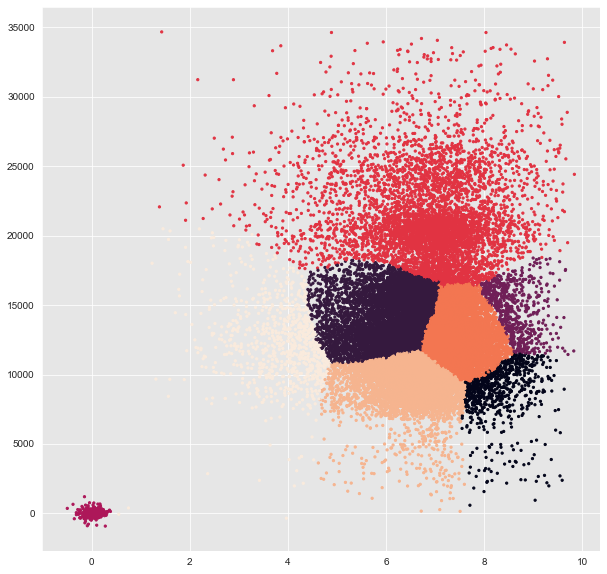

In [1409]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
scatter_clusters = ax.scatter(rating_for_cluster, 
                            revenues_for_cluster,
                            c=y_pred_cluster, 
                            s=5)


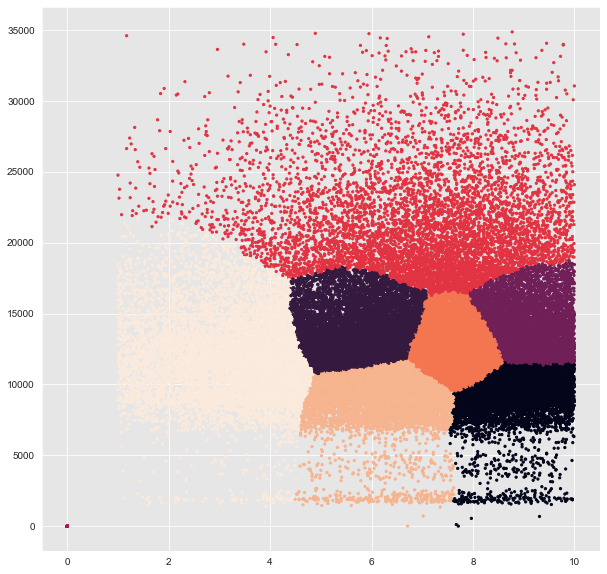

In [1410]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
scatter_clusters_2 = ax.scatter(hotel['Customer Satisfaction Rating'], 
                            hotel['ADR Weighted'],
                            c=hotel['Cluster'], 
                            s=5)


# References



# Final Remarks
in some regard in a simplified way 
This is relatively simple approach, due also to the limitation of the data. More data and higher quality of them will allow better tailored solutions. Especially, the level of detail of the forecast. Furthermore, since data are anonymized and partly randomized, correlation is spurious. Results, due to these reasons, lack significance, but I endorse/back the process' correctness.
The assumption of the present approach is that customer satisfaction, ADR and in-house up- and cross-selling can be better explained by behavioural and demographic factors of the customers hosted.
Worth to be noted, this dataset is not representative of real customers, and any pattern identified will depend on the specific case to which is applied.
Concluding, this approach to market segmentation focuses on two core aspects, revenues and customer satisfaction. As referenced in the [References](#References), a common metric used for segmenting in BI literature is RFM. I am not arguing for an absolute superiority of my approach. In fact, key metrics will be dependent upon the individual strategic goal of the company, its priorities, historical customers, and previous experiences.
Why not RFM: In fact, whereas the monetary aspect is quite straightforward, the choice of rating is dependent upon the satisfaction of the customers. The underlying reason is that I ought to seek happy customers, rather than returning ones. There might be endogeneity, but I find that rather than having just returning customers, having happy customers is more relevant in a globalized world, with young and people in general that are accustomed on visiting more places and rarely returning to the same place, looking for new experiences (pre-covid, as the project has been). Hence, having high satisfaction is then reflected on social media and pivotal in attracting more customers, hence allowing the hotel-(chain) revenue team to charge higher prices, instantiating a virtuous circle, an upward spiral.

~~* I cannot do RFM to compare because I lack ID of customers. I only know if they have been returning. Maybe I could create a feature Returning+Rating. But do you really care if they return? Less marketing expenditures?  I still don't like the definition of RECENCY-FREQUENCY*~~


# To_csv and Importing - Temporary

In [76]:
# hotel_persons.to_csv('hotel.csv')
# hotel_sc.to_csv('hotel_sc.csv')

In [2]:
# hotel_persons = pd.read_csv('clustered.csv')
hotel_sc = pd.read_csv("hotel.csv") # pd.read_csv('hotel_sc.csv')

In [386]:
hotel_sc['col3'] = hotel_sc['Country'].astype('category')

In [387]:
hotel_sc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11695 entries, 0 to 11694
Data columns (total 45 columns):
Unnamed: 0                               11695 non-null int64
index                                    11695 non-null int64
level_0                                  11695 non-null int64
IsCanceled                               11695 non-null int64
LeadTime                                 11695 non-null int64
Adults                                   11695 non-null int64
Children                                 11695 non-null int64
Babies                                   11695 non-null int64
Meal                                     11695 non-null object
Country                                  11695 non-null category
Travelling Group                         11695 non-null object
Distribution Channel                     11695 non-null object
Is Repeated Guest                        11695 non-null int64
Previous Cancellation                    11695 non-null int64
Previous Bookings

In [381]:
hotel_sc.head()

,Unnamed: 0,index,level_0,IsCanceled,LeadTime,Adults,Children,Babies,Meal,Country,Travelling Group,Distribution Channel,Is Repeated Guest,Previous Cancellation,Previous Bookings Not Cancelled,Reserved Room Type,Assigned Room Type,Booking Changes,Deposit Type,Agent,Company,Customer Type,Required Car Parking Spaces,# Special Requests,Reservation Status,Age,Nights,ADR,Bar,Restaurant,Breakfast,Other,Additional Expenditures,Arrival Date,Customer Satisfaction Rating,Average Daily Revenues,Total Revenues,Average Daily Revenues - Scaled,Customer Satisfaction Rating - Scaled,Persons,Revenues per Person,Daily Revenues per Person,Daily Revenues per Person - Scaled,Cluster,col3
0,0,0,9734,1,1,2,0,0,BB,Denmark,Business,Undefined,0,0,0,B,B,0,No Deposit,14,NULL,Transient-Party,0,1,Canceled,23,2,276.0,364,0,0,0,0,2016-08-05,7.710938,276.000000,552.0,0.030792,0.771697,2,276.0,138.000000,0.021863,4,Denmark
1,1,1,9734,1,1,2,0,0,BB,Denmark,Business,Undefined,0,0,0,B,B,0,No Deposit,14,NULL,Transient-Party,0,1,Canceled,23,2,276.0,364,0,0,0,0,2016-08-05,7.710938,276.000000,552.0,0.030792,0.771697,2,276.0,138.000000,0.021863,4,Denmark
2,2,2,3421,0,40,0,2,0,BB,Spain,Family,TA/TO,0,0,0,B,B,1,No Deposit,9,NULL,Transient,0,1,Check-Out,9,3,138.0,0,925,158,27,1110,2016-07-14,5.289062,508.000000,1524.0,0.056671,0.529320,2,762.0,254.000000,0.040241,0,Spain
3,3,3,3421,0,40,0,2,0,BB,Spain,Family,TA/TO,0,0,0,B,B,1,No Deposit,9,NULL,Transient,0,1,Check-Out,9,3,138.0,0,925,158,27,1110,2016-07-14,5.289062,508.000000,1524.0,0.056671,0.529320,2,762.0,254.000000,0.040241,0,Spain
4,4,4,11498,0,104,0,2,0,BB,France,Family,TA/TO,0,0,0,B,B,1,No Deposit,7,NULL,Transient-Party,0,2,Check-Out,53,3,138.0,0,1058,224,18,1300,2016-08-11,6.210938,571.333313,1714.0,0.063721,0.621579,2,857.0,285.666667,0.045258,0,France


# Limitations

- classifications are made not considering the time dimension. In terms of seasonality, cycles, ...

- selection bias as in Part 1. For studying purposes, I could strip some ratings and then trying to synthetize that missing data first with multivariate algo (MICE, random forest, ...)

# Next Projects

- **time Series on central bank data and Granger causality**
- PySpark
- SMOTE
- Lasso and feature selection
- Feature selection

**PYSPARK FOR THIS** or parallelize 
> https://docs.python.org/3/library/multiprocessing.html

Kaggle on pharma stuff: https://www.kaggle.com/c/lish-moa/data?select=train_features.csv

In [ ]:
""" SMOTE """
# I could simply delete, since are few. Buuuut, let's see. Maybe just put as closest to average adults/children
# do this in credit rating

hotel.loc[(hotel['Adults']==0)&(hotel['Children']==0)&(hotel['Babies']==0)&(hotel['Nights']!=0)]